# Problem statement
In this competitive world where IT operations are happening round the clock 24 hours, every organization yearns for quickly resolving encountered incidents to have no or minimal business impact.<br>
IT leverages incident management process to achieve this objective which after analyzing the type of the incident assign it to the respective groups to resolve the incident.<br>
In this Capstone project, the goal is to build a classifier that can classify the tickets by analyzing text. 


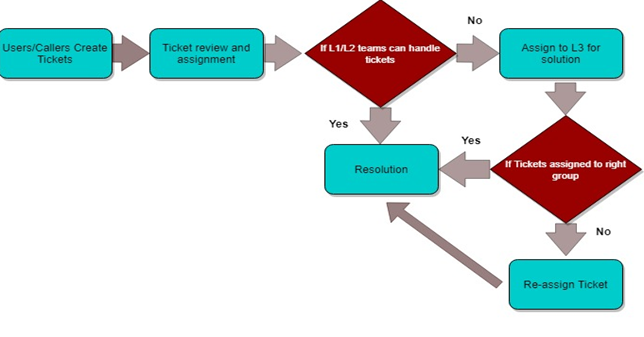

## Approach

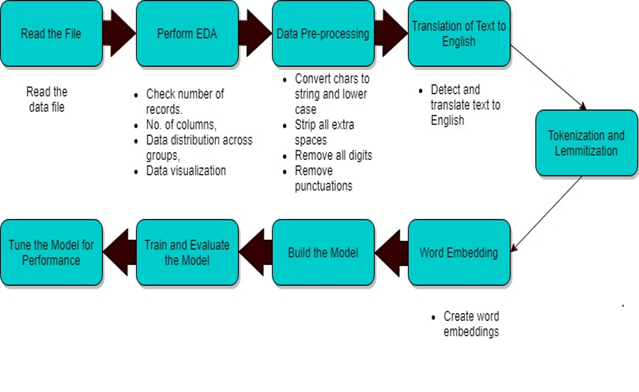

Details about the data and dataset files are given in below link,<br> 
https://drive.google.com/file/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ


# Installing Prerequisite Libraries

In [0]:
!pip install langdetect
!pip install googletrans

# Importing Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, homogeneity_score, silhouette_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn import model_selection, svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPool1D, SpatialDropout1D, GRU
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from collections import OrderedDict, Counter

import re

import string
from string import punctuation as punc

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.util import ngrams

from wordcloud import WordCloud, STOPWORDS 

from textblob import TextBlob
from tqdm import tqdm

from spacy.lang.en import English

import googletrans
from googletrans import Translator

from langdetect import detect, DetectorFactory

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Mounting Drive and read file

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = '/content/drive/My Drive/GL AIML/Capstone'
os.chdir(project_path)

In [0]:
df = pd.read_excel('Input Data Synthetic (created but not used in our project).xlsx')

# Data understanding

In [0]:
df.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

<font color='blue'>The dataset consists of four variables. The summary explanation is given as below:<br>
1)	Short Description: This is a text column. It contains generic word combinations to describe the issue that has been logged by the user. Have null values.<br>
2)	Description: This is a text column. It has the detail description of the ticket. It contains unformatted, junk, multilanguage data. Have null values<br>
3)	Caller: This is a text column. It contains the name of the caller Doesn’t have null values<br>
4)	Assignment Group: The group/ level number to which the tickets were assigned to. This is our target variable. Doesn’t have null values.
</font>


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
Short description    8492 non-null object
Description          8499 non-null object
Caller               8500 non-null object
Assignment group     8500 non-null object
dtypes: object(4)
memory usage: 265.8+ KB


<font color='blue'> Dataset has total 8500 rows and 4 variables/columns. <br> 
1 Target variable - Assignment Group<br>
3 independent variables - Short description, Description, Caller<br>
All Variables are of String type.<br><br>
Column Description has 1 Null value <br>
Short Description has 8 Null values. <br>
Caller and Assignment group doesn't have any NULL values
Let's check which all index in the dataset has null values</font>

In [0]:
# Find index of NaN values
SD_nan_index = df.loc[pd.isna(df["Short description"]), :].index
Desc_nan_index = df.loc[pd.isna(df['Description']),:].index
print('Short description null at index ', SD_nan_index)
print('Short description null at index ', Desc_nan_index)

Short description null at index  Int64Index([2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341], dtype='int64')
Short description null at index  Int64Index([4395], dtype='int64')


In [0]:
#Converting all rows to String 
df['Short description']=df['Short description'].apply(str)
df['Description']=df['Description'].apply(str)
df['Caller']=df['Caller'].apply(str)

# EDA - Let's Visualize the Data distributrion

## Let's look at the distribution of our dataset based on Individual features

### Dataset Distribution by "Assignment Group"

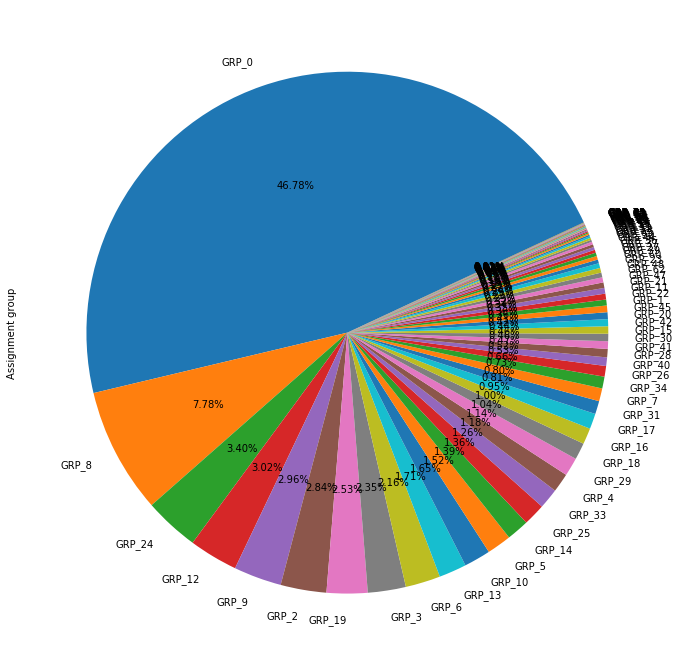

In [0]:
plt.figure(figsize=(20,12))
df["Assignment group"].value_counts().plot.pie(autopct='%1.2f%%', fontsize=10, startangle=25)

<font color='blue'> The above chart shows that the dataset is highly imbalanced based on 'Assignment Group' and it would have large impact on our Classification Model Accuracy.<br>
The dataset consists of 74 unique groups with GRP_0 holding the maximum distribution of around 47%.<br> Other major groups are GRP_8 and GRP_24 holding around 7.8% and 3.4% There are more than 35 groups which holds less then 2% of the total distribution.<br>
In later stage, we would see how can we handle the Dataset Imbalancing Problem.<br>
Let's pull the same distribution in bar chart below.</Font>

Text(0, 0.5, 'Assignment Groups')

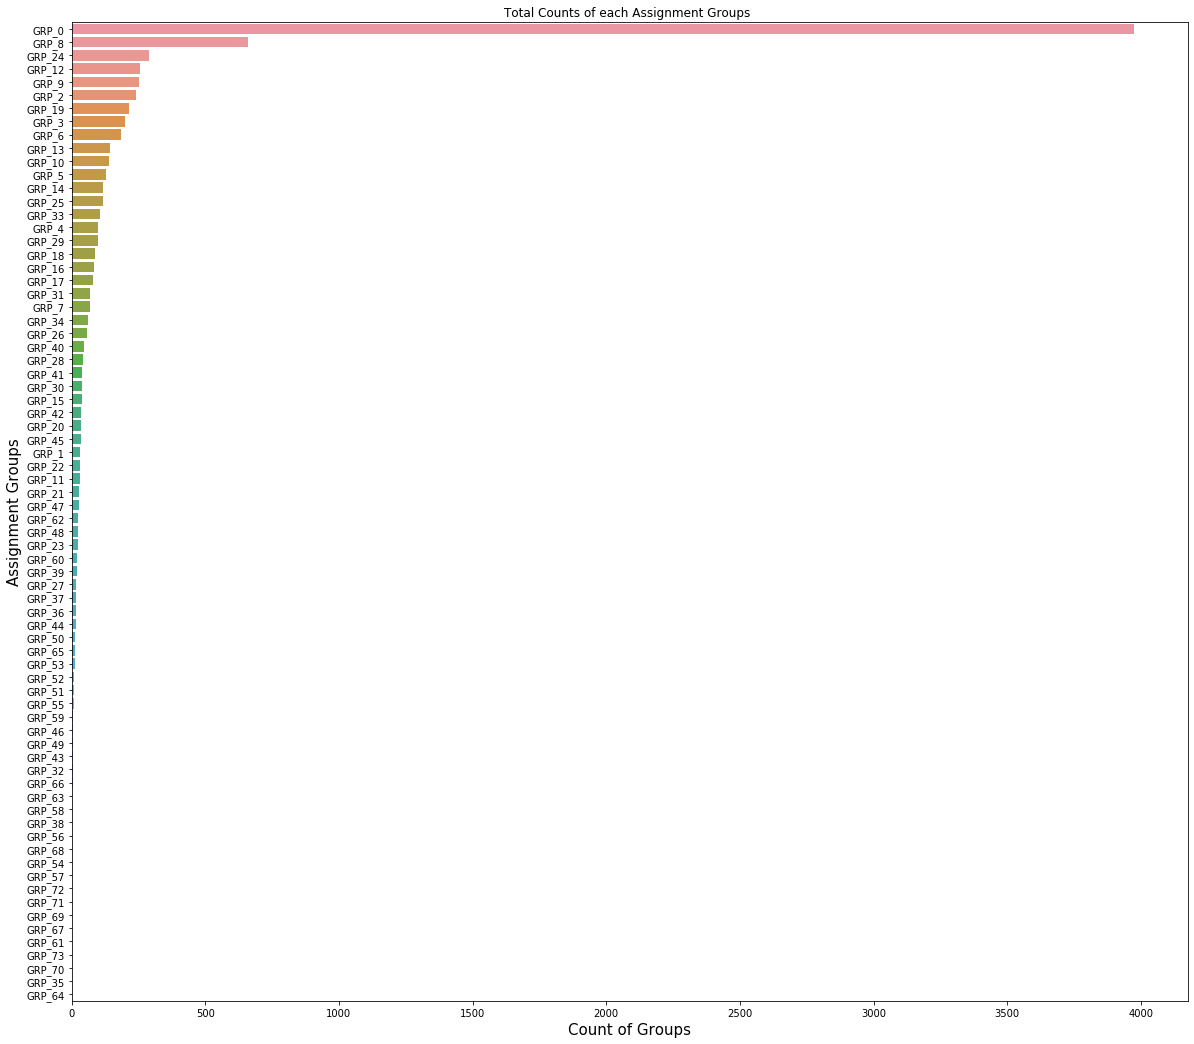

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,18))


x = df['Assignment group'].value_counts()
sns.barplot(x, x.index, ax=ax1)
plt.title('Total Counts of each Assignment Groups ')
plt.gca().set_xlabel('Count of Groups',fontsize=15)
plt.gca().set_ylabel('Assignment Groups',fontsize=15)

### Dataset Distribution by "Caller"

Text(0, 0.5, 'Callers')

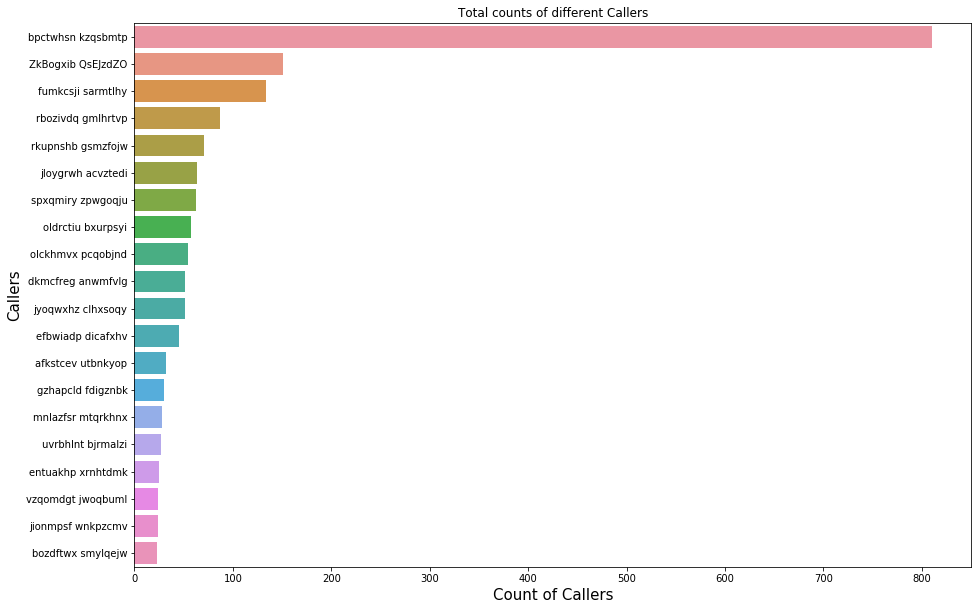

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))

x = df.groupby(['Caller']).size().sort_values(ascending=False).head(20)
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of different Callers')
plt.gca().set_xlabel('Count of Callers',fontsize=15)
plt.gca().set_ylabel('Callers',fontsize=15)

<font color='blue'> "<b> bpctwhsn kzqsbmtp</b> " is the end user who has reported maximum number of tickets. So we assume, it has relationship towards prediction of Assignment group classification.<br><br>
Let's see which group most of his ticket is assigned to<font>

In [0]:
df[df['Caller']=='bpctwhsn kzqsbmtp']['Assignment group'].value_counts()

GRP_8     362
GRP_9     153
GRP_5      96
GRP_6      89
GRP_10     60
GRP_60     16
GRP_12      8
GRP_45      7
GRP_1       6
GRP_13      4
GRP_18      3
GRP_47      2
GRP_29      1
GRP_57      1
GRP_44      1
GRP_14      1
Name: Assignment group, dtype: int64

<font color='blue'> let's see what all type of issues group 8 and group 9 are resolving<font>

In [0]:
#Group by ShortDescription and Group
dfSDG = df.groupby(['Short description','Assignment group']).size().sort_values(ascending=False).reset_index()

dfSDG[dfSDG['Assignment group']=='GRP_8']['Short description'].head(8)

45     job Job_3028 failed in job_scheduler at: 08/24...
115                abended job in job_scheduler: Job_593
138    job Job_549 failed in job_scheduler at: 10/07/...
157    abended job in job_scheduler: bkbackup_tool_re...
160    abended job in job_scheduler: bk_hana_SID_62_e...
161    abended job in job_scheduler: bk_hana_SID_62_e...
166    job Job_749 failed in job_scheduler at: 08/27/...
167    job SID_41arc2 failed in job_scheduler at: 08/...
Name: Short description, dtype: object

In [0]:
#Group by ShortDescription and Group
dfSDG = df.groupby(['Short description','Assignment group']).size().sort_values(ascending=False).reset_index()

dfSDG[dfSDG['Assignment group']=='GRP_9']['Short description'].head(8)

52     abended job in job_scheduler: Job_1148
55     abended job in job_scheduler: Job_1141
92     abended job in job_scheduler: Job_1320
104    abended job in job_scheduler: Job_1142
113    abended job in job_scheduler: Job_2114
207    abended job in job_scheduler: Job_1305
243               update of ae to bw and hana
519                           issue with bobj
Name: Short description, dtype: object

<font color='blue'>We could see maximum incidents raised by “bpctwhsn kzqsbmtp” user and most of the issue are Job Failure related.<br> We assume the person may be from Operations team raising incidents for L2/L3 team.</font>

### Dataset Distribution by "Short Description"

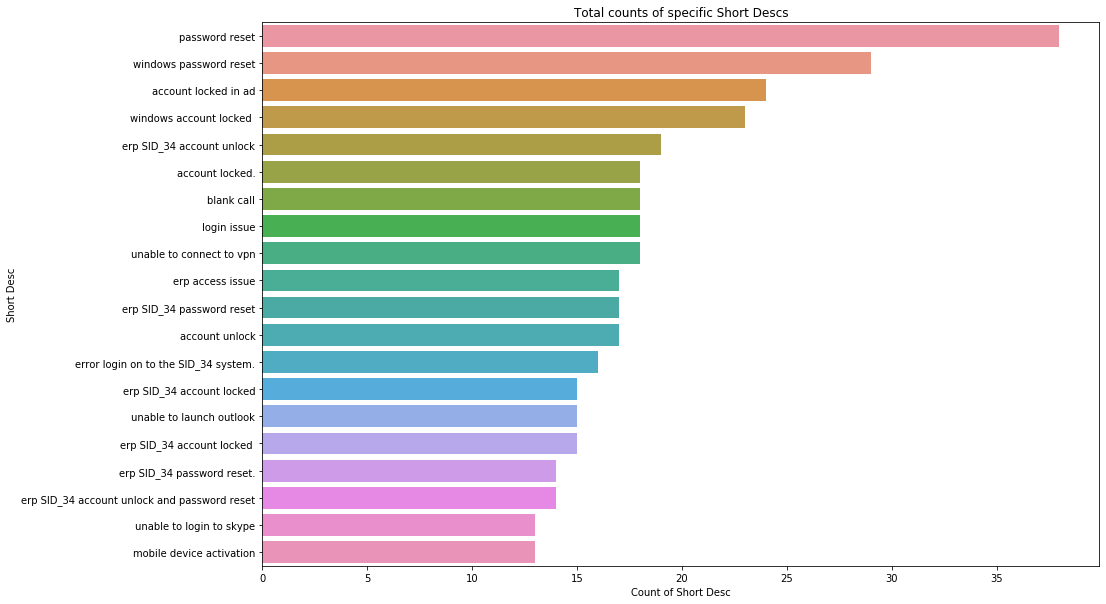

In [0]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))

x = df['Short description'].value_counts()[:20]
sns.barplot(x, x.index, ax=ax1)
plt.title('Total counts of specific Short Descs')
plt.gca().set_xlabel('Count of Short Desc')
plt.gca().set_ylabel('Short Desc')

plt.show()

<font color='blue'> Password reset is the type of issue, which is reported most of the time.</font>

# Let's do some feature engineering, EDA and preprocessing of data

In [0]:
df_en = df.copy()

In [0]:
df_en.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [0]:
#Converting all rows to String 
df_en['Short description']=df_en['Short description'].apply(str)
df_en['Description']=df_en['Description'].apply(str)
df_en['Caller']=df_en['Caller'].apply(str)

## Removing Caller Name from Description Feature

In [0]:
caller_list = df_en["Caller"].str.split(" ", n = 1, expand = True)

caller_fname = caller_list[0]
caller_lname = caller_list[1]

caller_fname_list = caller_fname.to_list()
caller_lname_list = caller_lname.to_list()

df_en.Description = df_en.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_fname_list]))
df_en.Description = df_en.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_lname_list]))

In [0]:
#Let's combine all 3 independent attribute to 1
df_en['Complete_Description'] = df_en['Short description'].str.cat(df_en['Description'],sep=" ")
#remove unnecessary spaces
df_en.Complete_Description = df_en.Complete_Description.apply(lambda x: x.strip())

In [0]:
#Remove non consecutive duplicates
df_en['Complete_Description'] = (df_en['Complete_Description'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

In [0]:
df_en.head(2)

Short description  ...                               Complete_Description
0       login issue  ...  login issue -verified user details.(employee# ...
1           outlook  ...  outlook received from: hmjdrvpb.komuaywn@gmail...

[2 rows x 5 columns]

## As all 3 independent attributes are merged into 1 column, let's remove those columns from dataframe

In [0]:
#As all 3 independent attributes are merged into 1 column, let's remove those columns from dataframe
df_en.drop(['Short description','Description','Caller'], axis=1, inplace=True)
df_en.head()

Assignment group                               Complete_Description
0            GRP_0  login issue -verified user details.(employee# ...
1            GRP_0  outlook received from: hmjdrvpb.komuaywn@gmail...
2            GRP_0  cant log in to vpn received from: eylqgodm.ybq...
3            GRP_0                      unable to access hr_tool page
4            GRP_0                                        skype error

## We will extract some basic text features such as: <br>
    Number of words<br>
    Number of characters<br>
    Number of stopwords<br>
    Number of special characters<br>
    Number of numerics<br>
    Number of uppercase words<br>
    sentiment analysis<br>
    Non English Descriptions
    and so on...


In [0]:
nltk.download('stopwords')
stop = stopwords.words('english')

stop_words = []
stop_words += ["sr", "psa", "perpsr", "psa", "good", "evening", "will", "night", "afternoon","png", "mailto" "ca","nt","at" "i", "vip", "llv", "xyz", "cid", "image", "gmail","co", "in", "com", "ticket", "company", "received", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### WordCloud with Stopwords

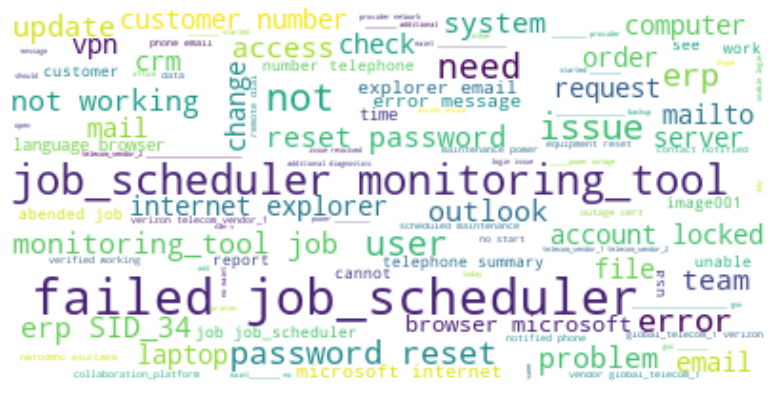

In [0]:
#Word Cloud
text = " ".join(review for review in df_en['Complete_Description'])
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Basic text Analysis

In [0]:
#df_en.Description=='nan'
def missing_val(text):
  if text=='nan':
    output='True'
  else:
    output='False'
  return output

In [0]:
def get_sentiment(text):
  sentiment = TextBlob(text).sentiment
  return sentiment[0]

In [0]:
translator = Translator()
languages = googletrans.LANGUAGES

In [0]:
DetectorFactory.seed = 0

In [0]:
def count_regexp_occ(regexp='', text=None):
    return len(re.findall(regexp, text))   

In [0]:
def txtAnalysis(data, column):
  data['word_count'] = data[column].apply(lambda x : len(x.split(" ")))
  data['char_count'] = data[column].str.len()
  data['word_density'] = data['word_count'] / (data['char_count'] + 1)
  data['punc_count'] = data[column].apply(lambda x : len([a for a in x if a in punc]))
  data['stopwords'] = data[column].apply(lambda x: len([x for x in str(x).split() if x in stop]))
  data['numerics'] = data[column].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
  data['upper'] = data[column].apply(lambda x: len([x for x in x.split() if x.isupper()]))
  data['sentiment'] = data[column].apply(lambda x : TextBlob(x).sentiment[0])
  data['is_null'] = data[column].apply(lambda x : missing_val(x))
  #data['is_english'] = data[column].apply(lambda x : True if isEnglish(x) else False)
  data['Language'] = data[column].apply(lambda x: detect(x))
  data['Language'] = data['Language'].apply(lambda x: languages[x].upper())
  data['num_symbols'] = data[column].apply(lambda x: sum(x.count(w) for w in '*#&$%?!'))
  data['num_unique_words'] = data[column].apply(lambda x: len(set(w for w in x.split())))
  data['num_smilies'] = data[column].apply(lambda x: sum(x.count(w) for w in (':-)', ':)', ';-)', ';)')))
  # Count number of \n
  data['num_slash_n'] = data[column].apply(lambda x: count_regexp_occ(r"\n", x))
  # Check for time stamp
  data['has_timestamp'] = data[column].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
  # Check for http links
  data['has_http'] = data[column].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
  return data.head(5)

In [0]:
df_eda = df_en.copy()
txtAnalysis(df_eda, 'Complete_Description')

Assignment group  ... has_http
0            GRP_0  ...        0
1            GRP_0  ...        0
2            GRP_0  ...        0
3            GRP_0  ...        0
4            GRP_0  ...        0

[5 rows x 18 columns]

### English Vs Non English Description text Distribution

In [0]:
english_tickets = len(df_eda[df_eda['Language'] == 'ENGLISH'])
non_english_tickets = len(df_eda[df_eda['Language'] != 'ENGLISH'])
languages = pd.DataFrame(columns=['Language','Percentage'])
languages = languages.append({'Language':'English', 'Percentage':(english_tickets/8500)*100}, ignore_index=True)
languages = languages.append({'Language':'Non-English', 'Percentage':(non_english_tickets/8500)*100}, ignore_index=True)
languages

Language  Percentage
0      English   82.764706
1  Non-English   17.235294

<font color='blue'> In our dataset, we have 17% of Non-English texts, As our dataset has only 8500 of data points, so if we ignore 17% of non-english data points, then we may not build a good model. <br>
So, we will handle the non-english datapoints</font>

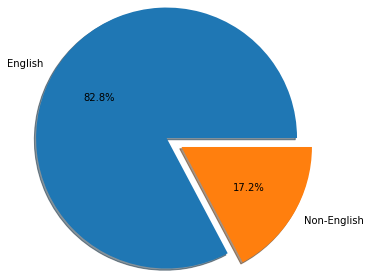

In [0]:
# Pie chart for English Vs Non-English languages
plt.figure(figsize=(4,4))
plt.pie(data=languages, x = 'Percentage', labels='Language', radius=1.5, shadow=True, autopct='%1.1f%%', explode=(0,0.2))
plt.savefig("LanguagesDist.png")

In [0]:
df_eda.groupby('Language')['Language'].count().sort_values(ascending=False)

Language
ENGLISH       7035
GERMAN         381
AFRIKAANS      255
FRENCH         146
ITALIAN        125
NORWEGIAN       91
CATALAN         80
DANISH          77
SWEDISH         76
DUTCH           58
SPANISH         38
POLISH          31
PORTUGUESE      25
FILIPINO        12
WELSH           12
ROMANIAN        11
ALBANIAN        10
SLOVENIAN        7
FINNISH          5
ESTONIAN         5
CROATIAN         5
INDONESIAN       5
TURKISH          4
LITHUANIAN       2
CZECH            2
LATVIAN          1
SLOVAK           1
Name: Language, dtype: int64

<font color='blue'> we could see our dataset has quite lots of different languages</font>

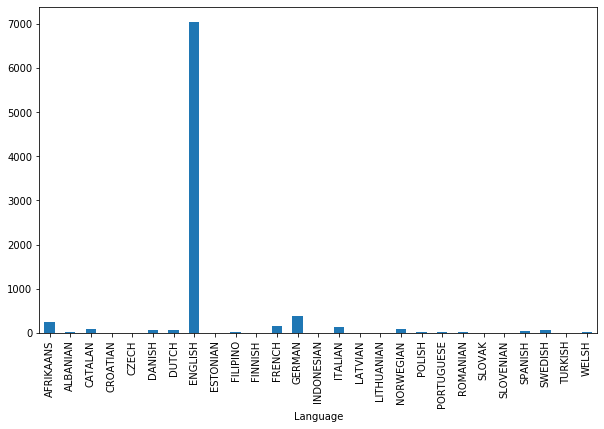

In [0]:
plt.figure(figsize=(10,6))
df_eda.groupby('Language')['Language'].count().plot.bar()

In [0]:
df_eda.describe()

word_count   char_count  ...  has_timestamp  has_http
count  8500.000000  8500.000000  ...    8500.000000    8500.0
mean     23.176353   173.733176  ...       5.031176       0.0
std      38.950384   335.434937  ...      31.995243       0.0
min       1.000000     1.000000  ...       0.000000       0.0
25%       6.000000    44.000000  ...       0.000000       0.0
50%      12.000000   103.000000  ...       1.000000       0.0
75%      28.000000   198.000000  ...       6.000000       0.0
max     981.000000  8753.000000  ...    1016.000000       0.0

[8 rows x 14 columns]

<font color='blue'>
We draw below key insights:<br>
1)	There are around 25 words present in each column on an average with character count reaching to 192. <br>
2)	On an average 5 stop words are present in each entry along with 15 punctuations. <br>
3)	There are numerical values present in the dataset with a mean of 0.5. <br>
4)	Upper case and alphanumeric characters are present.<br>
5)	Dataset doesn't contains URL links (http) but has some timestamp values. </font>


In [0]:
df_eda.sort_values(by='word_count', ascending=False).head(5)

Assignment group  ... has_http
4089            GRP_2  ...        0
4087           GRP_39  ...        0
5433            GRP_2  ...        0
7997            GRP_2  ...        0
8002           GRP_62  ...        0

[5 rows x 18 columns]

In [0]:
print("Maximum number of words used in the description: ",df_eda.word_count.max())

Maximum number of words used in the description:  981


In [0]:
print("Maximun number of characters used in the description: ",df_eda.char_count.max())

Maximun number of characters used in the description:  8753


In [0]:
print("Maximun number of punctuations used in the description: ",df_eda.punc_count.max())

Maximun number of punctuations used in the description:  2296


In [0]:
print("Maximun number of stopwords used in the description: ",df_eda.stopwords.max())

Maximun number of stopwords used in the description:  59


In [0]:
print("Maximun number of numerics/digits used in the description: ",df_eda.numerics.max())

Maximun number of numerics/digits used in the description:  271


## Let's visualize the features that we extracted above

### Word Density Distribution

Text(0.5, 1.0, 'Histogram of Word Density')

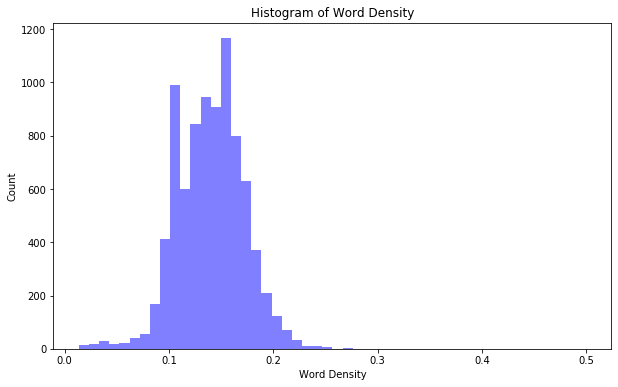

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.word_density, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Density')
plt.ylabel('Count')
plt.title('Histogram of Word Density')

### Word Count Distribution

Text(0.5, 1.0, 'Histogram of Word Count')

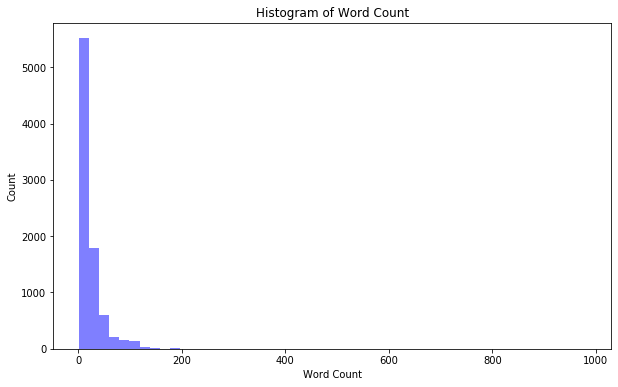

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Histogram of Word Count')

### Punctuation count Distribution

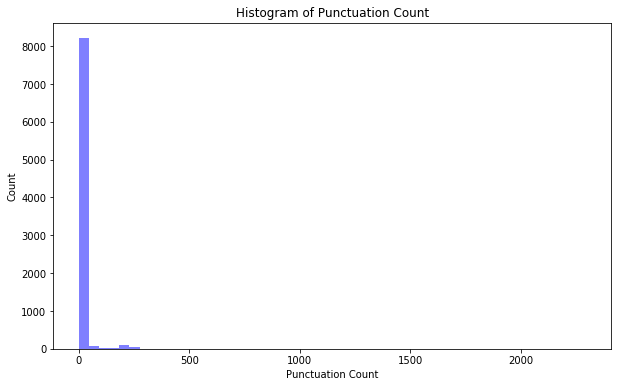

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.punc_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.title('Histogram of Punctuation Count')
plt.show();

### Stopwords count Distribution

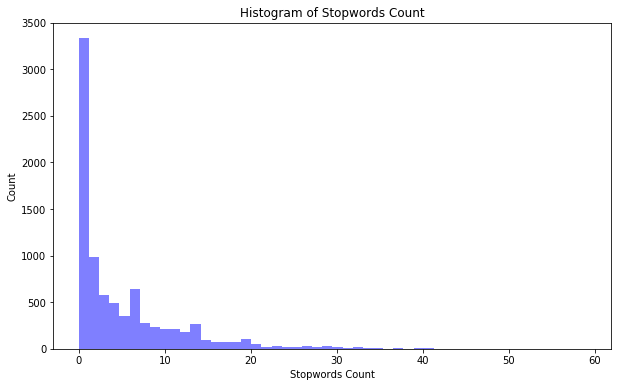

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.stopwords, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Stopwords Count')
plt.ylabel('Count')
plt.title('Histogram of Stopwords Count')
plt.show();

### Word count and stopwords Distribution

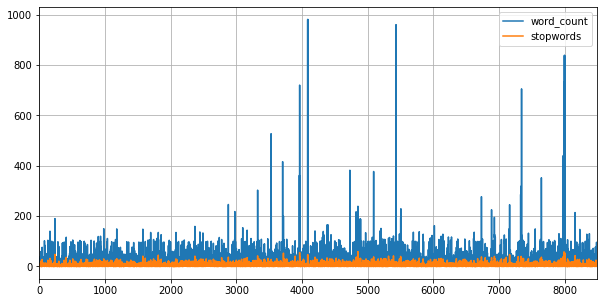

In [0]:
df_eda[['word_count','stopwords']].plot(figsize=(10,5), grid=True)

### Word count and punctuation count Distribution

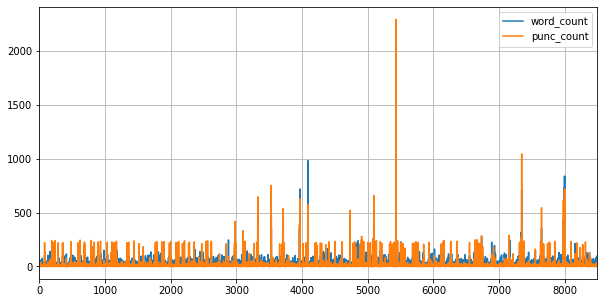

In [0]:
df_eda[['word_count','punc_count']].plot(figsize=(10,5), grid=True)

<font color='blue'> looks like data has more punctuations. We will handle the same in later stage </font>

### Numerics count distribution

Text(0.5, 1.0, 'Histogram of Numeric Count in Description')

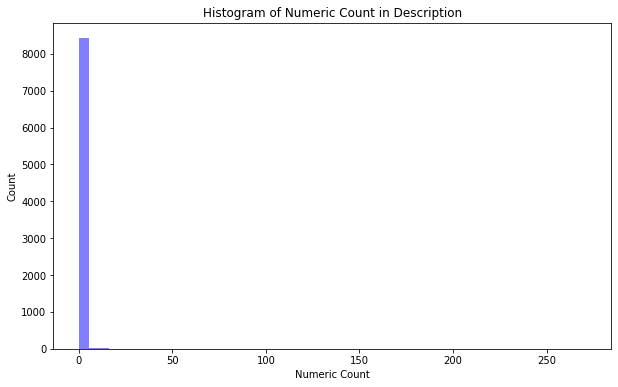

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.numerics, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Numeric Count')
plt.ylabel('Count')
plt.title('Histogram of Numeric Count in Description')

### Null values Distribution after merging short description and description columns

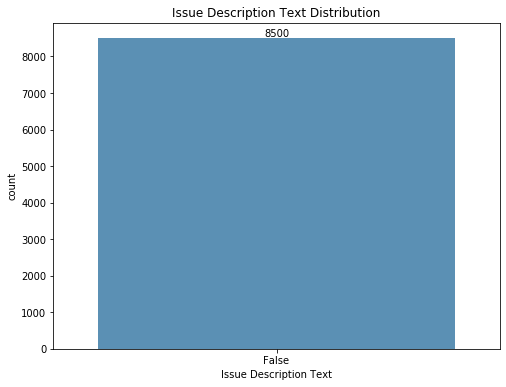

In [0]:
x=df_eda['is_null'].value_counts()
x=x.sort_index()
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Issue Description Text Distribution")
plt.ylabel('count')
plt.xlabel('Issue Description Text')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Sentiment Analysis Distribution

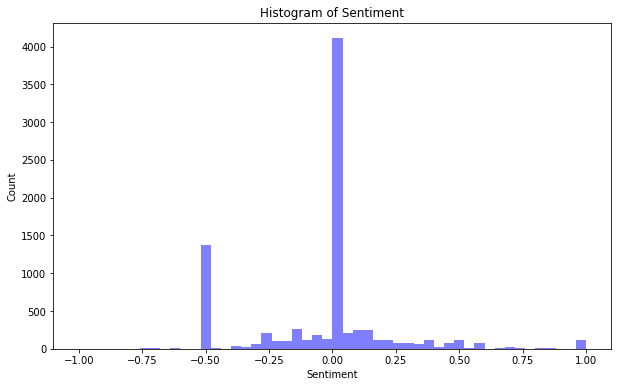

In [0]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_eda.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Histogram of Sentiment')
plt.show();

#### Let's see the text based on the sentiment

##### Positive selntiment texts

In [0]:
print('3 random Description with the highest positive sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == 1, ['Complete_Description']].sample(3).values
for c in cl:
    print(c[0])
    print('---------------------')

3 random Description with the highest positive sentiment: 

*********************************************************
password cannot changed received from: tbukjcyl.lxncwqbj@gmail.com dear all could you please help me to fix it, [cid:image001.jpg@01d1f978.729627d0] best
---------------------
email-anzeige received from: trgqbeax.hfyzudql@gmail.com [cid:image001.png@01d1f7b0.223a83e0] leider ist das feld â€žvon" abhanden gekommen â˜¹ danke + viele grÃ¼ÃŸe mit freundlichen grÃ¼ÃŸen | best
---------------------
unlock erp logon received from: jofvunqs.uwigjmzv@gmail.com hello: please help me logon. i can not the system ,input my password. best
---------------------


##### Neutral sentiment texts

In [0]:
print('3 random Description with the Neutral sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == 0, ['Complete_Description']].sample(3).values
for c in cl:
    print(c[0])
    print('---------------------')

3 random Description with the Neutral sentiment: 

*********************************************************
password reset and access to reporting_engineering_tools
---------------------
erp SID_34 account locked.
---------------------
phishing emails uacyltoe hxgaycze query
---------------------


##### Negative sentiment texts

In [0]:
df_eda.sentiment.min()

-1.0

In [0]:
print('Description with the most negative sentiment: \n')
print('*********************************************************')
cl = df_eda.loc[df_eda.sentiment == -1.0, ['Complete_Description']].values
for c in cl:
    print(c[0])

Description with the most negative sentiment: 

*********************************************************
pls. help to run out dn under sto#5019320060,thx! received from: wktesmbp.lorjymef@gmail.com dear team, we got a stock recall notic#plant_101-101016-01 for mm#3098450 & should return 373pc materials plant_101,then i created sto#5019320060 base on this recall. dn#916955708/105pc was just against the sto, of rest 268pc ,thx lot! [cid:image001.png@01d223c2.0ac78080] b.rgds judthtihty.zhuyhts company hardpoint apac-wgq dc


### Most Common and Rare words

#### Most Common

In [0]:
Counter(" ".join(df_eda['Complete_Description']).split() ).most_common(20)

[('to', 3316),
 ('in', 2642),
 ('the', 2555),
 ('from:', 2445),
 ('received', 2329),
 ('is', 1937),
 ('not', 1688),
 ('on', 1592),
 ('and', 1545),
 ('please', 1524),
 ('for', 1482),
 ('i', 1261),
 ('a', 1164),
 ('of', 1052),
 ('it', 1017),
 ('job', 997),
 ('erp', 969),
 ('monitoring_tool@company.com', 961),
 ('password', 937),
 ('unable', 870)]

#### Rare words

In [0]:
#Least Word Freq
pd.set_option('display.max_colwidth', -1)

S = pd.Series(" ".join(df_eda['Complete_Description']).split() ).value_counts().sort_values(ascending=True)
df_least_word_freq = pd.DataFrame(S).reset_index()
df_least_word_freq.columns = ['word', 'count']
df_least_word_freq[df_least_word_freq['count'] < 5]

word  count
0      imaginal                     1    
1      12:43:00                     1    
2      xgrhplvk.coejktzn@gmail.com  1    
3      outside:192.168.0.109/135    1    
4      krcscfpr061y                 1    
...             ...                ..    
27874  456e                         4    
27875  crashed                      4    
27876  easy                         4    
27877  ÑƒÐ²Ð°Ð¶ÐµÐ½Ð¸ÐµÐ¼,          4    
27878  remember                     4    

[27879 rows x 2 columns]

### Preprocessing

In [0]:
dfTicketAssign =  df_eda.copy()

In [0]:
dfTicketAssign.head()

Assignment group  ... has_http
0  GRP_0            ...  0      
1  GRP_0            ...  0      
2  GRP_0            ...  0      
3  GRP_0            ...  0      
4  GRP_0            ...  0      

[5 rows x 18 columns]

#### Basic Preprocessing

In [0]:
regexList = ['From:(.*)\r\n',
 'IiNnCc[0-9]*',
 'ticket[_]*[\\s]*[0-9]*',
 'Sent:(.*)\r\n',
 'Received:(.*)\r\n',
 'To:(.*)\r\n',
 'CC:(.*)\r\n',
 '\\[cid:(.*)]',
 'https?:[^\\]\n\r]+',
 'Subject:',
 '[0-9][\\-0–90-9 ]+',# phones
 '[0-9]',# numbers
 '[^a-zA-z 0-9]+',# anything that is not a letter
 '[\r\n]',# single letters
 ' [a-zA-Z] ',  # two-letter words
 '  ', # double spaces
 '^[_a-z0-9-]+(\\.[_a-z0-9-]+)*@[a-z0-9-]+(\\.[a-z0-9-]+)*(\\.[a-z]{2,4})$',
 '[\\w\\d\\-\\_\\.]+ @ [\\w\\d\\-\\_\\.]+',
 'Subject:',
 '[^a-zA-Z]',
 '\\S+@\\S+',# emails 
 "\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b" #IP Address
 ]

In [0]:
#Remove punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
          text = text.replace(punctuation, ' ')
    return text

In [0]:
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

In [0]:
#Translate tickets to English
def fn_translate(desc, lang):
  try:
    if lang == 'ENGLISH':
        return desc
    else:
        return translator.translate(desc).text
  except:
    return desc

In [0]:
def textPreprocessing(data,column):
  print("updating all cases to lower cases:")
  data[column] = data[column].apply(lambda x: " ".join(x.lower() for x in x.split()))
  print("Translating Non English to English:")
  data['EnglishDescription'] = data.apply(lambda x: fn_translate(x[column], x['Language']), axis=1)
  print("removing data using regular expression List:")
  for regex in regexList:
            data['EnglishDescription'] = removeString(data['EnglishDescription'], regex)
  print("removing stopwords:")            
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
  freq = pd.Series(' '.join(data['EnglishDescription']).split()).value_counts()[:20]
  print("removing top 20 Most common words:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  rare = pd.Series(' '.join(data['EnglishDescription']).split()).value_counts()[-20:]
  print("removing top 20 rare words ata using regular expression List:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
  print("removing punctuations:")
  data['EnglishDescription'] = data['EnglishDescription'].apply(remove_punctuations)
  return data.head(5)


In [0]:
dfTicketAssign.head()

Assignment group  ... has_http
0  GRP_0            ...  0      
1  GRP_0            ...  0      
2  GRP_0            ...  0      
3  GRP_0            ...  0      
4  GRP_0            ...  0      

[5 rows x 18 columns]

In [0]:
textPreprocessing(dfTicketAssign,'Complete_Description')

updating all cases to lower cases:
Translating Non English to English:
removing data using regular expression List:
removing stopwords:
removing top 20 Most common words:
removing top 20 rare words ata using regular expression List:
removing punctuations:


Assignment group  ...                                                                                      EnglishDescription
0  GRP_0            ...  login verified details employee manager checked advised check caller confirmed login resolved         
1  GRP_0            ...  outlook hmjdrvpb komuaywn team meetings skype meetings appearing calendar somebody advise correct kind
2  GRP_0            ...  cant log vpn eylqgodm ybqkwiam cannot                                                                 
3  GRP_0            ...  hr                                                                                                    
4  GRP_0            ...  skype                                                                                                 

[5 rows x 19 columns]

### Most Common words after preprocessing

In [0]:
counter = Counter(" ".join(dfTicketAssign['EnglishDescription']).split() ).most_common(20)
counter

[('system', 606),
 ('network', 591),
 ('outlook', 549),
 ('need', 546),
 ('vendor', 525),
 ('login', 523),
 ('power', 494),
 ('telecom', 481),
 ('message', 439),
 ('see', 412),
 ('phone', 404),
 ('outage', 401),
 ('team', 383),
 ('locked', 370),
 ('usa', 355),
 ('vpn', 341),
 ('update', 339),
 ('server', 337),
 ('number', 336),
 ('contact', 334)]

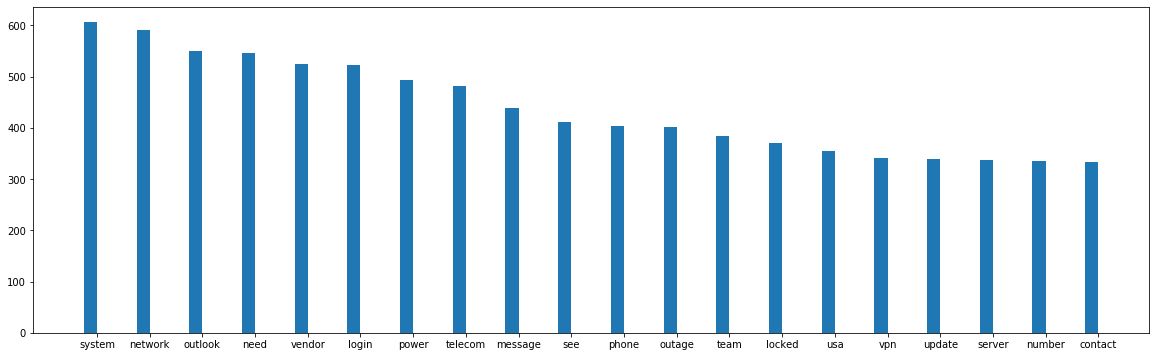

In [0]:
labels, values = zip(*Counter(" ".join(dfTicketAssign['EnglishDescription']).split() ).most_common(20))
plt.figure(figsize=(20,6))

indexes = np.arange(len(labels))
width = 0.25

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [0]:
pd.set_option('display.max_colwidth', -1)

S = pd.Series(" ".join(dfTicketAssign['EnglishDescription']).split() ).value_counts().sort_values(ascending=True)
df_least_word_freq = pd.DataFrame(S).reset_index()
df_least_word_freq.columns = ['word', 'count']
df_least_word_freq[df_least_word_freq['count'] < 5]

word  count
0      uncaught    1    
1      vbmzgsdk    1    
2      gerberghty  1    
3      stamped     1    
4      awnftgev    1    
...         ...   ..    
11353  outputs     4    
11354  soll        4    
11355  komuaywn    4    
11356  cyxieuwk    4    
11357  ufriscym    4    

[11358 rows x 2 columns]

#### Tokenization and Lemmatization

<font color='blue'> We performed basic cleaning of our dataset.<br>
Let's look into tokenization, N-grams and visualize how our dataset looks</font>

In [0]:
# Word tokenization
nlp = English()

In [0]:
def tokenizeText(text):
  #  "nlp" Object is used to create documents with linguistic annotations.
  my_doc = nlp(text)
  # Create list of word tokens
  token_list = []
  for token in my_doc:
    token_list.append(token.text)
  return token_list

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
dfTicketAssign['Tokens'] = dfTicketAssign['EnglishDescription'].apply(lambda x: tokenizeText(x))

In [0]:
#Cleaning stop words after tokenization
cleanTokens = []
for col_desc in range(len(dfTicketAssign.Tokens)):
  str_token = dfTicketAssign.Tokens[col_desc]
  cleanTokens.append([w for w in str_token if w not in stop_words] )

dfTicketAssign['Tokens'] = cleanTokens

In [0]:
# Python code to remove duplicate elements after tokenization
def RemovDupWordTokens(dupToken): 
    finalTokenlist = [] 
    for num in dupToken: 
        if num not in finalTokenlist: 
            finalTokenlist.append(num) 
    return finalTokenlist 

In [0]:
def lemmatizeText(text):
  text = ' '.join(map(str, text)) 
  # Implementing lemmatization
  lem = nlp(text)
  lemma_list = []
  # finding lemma for each word
  for word in lem:
    lemma_list.append(word.lemma_)
  return lemma_list
  #return list(set(lemma_list))

In [0]:
dfTicketAssign['LemmaWords'] = dfTicketAssign['Tokens'].apply(lambda x: lemmatizeText(x))

#### Word Cloud after Lemmatization

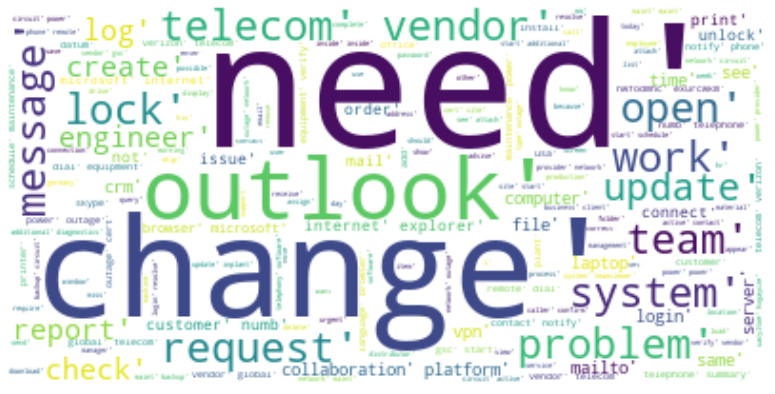

In [0]:
#Word Cloud
text = ' '.join(map(str, dfTicketAssign.LemmaWords))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
print('Average count of chars per Description cell is {0:.0f}.'.format(dfTicketAssign.groupby('Assignment group')['EnglishDescription'].count().mean()))

Average count of chars per Description cell is 115.


In [0]:
dfTicketAssign['LemmaWords'] = dfTicketAssign['LemmaWords'].apply(lambda x: RemovDupWordTokens(x))

#### Word Cloud after removing duplicates from Lemmatized words

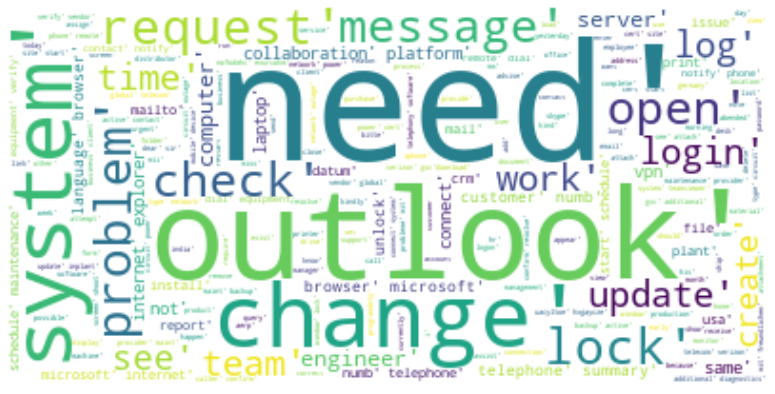

In [0]:
#Word Cloud
text = ' '.join(map(str, dfTicketAssign.LemmaWords))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### N-Grams

In [0]:
dfTicketngrams = dfTicketAssign.copy()

In [0]:
dfTicketngrams.head(5)

Assignment group  ...                                                                                              LemmaWords
0  GRP_0            ...  [login, verify, detail, employee, manager, check, advise, caller, confirm, resolve]                   
1  GRP_0            ...  [outlook, hmjdrvpb, komuaywn, team, meeting, skype, appear, calendar, somebody, advise, correct, kind]
2  GRP_0            ...  [log, vpn, eylqgodm, ybqkwiam, not]                                                                   
3  GRP_0            ...  [hr]                                                                                                  
4  GRP_0            ...  [skype]                                                                                               

[5 rows x 21 columns]

In [0]:
def get_top_ticketdesc_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(words_freq)
    return words_freq[:n]

[('system', 606), ('network', 591), ('outlook', 549), ('need', 546), ('vendor', 525), ('login', 523), ('power', 494), ('telecom', 481), ('message', 439), ('see', 412), ('phone', 404), ('outage', 401), ('team', 383), ('locked', 370), ('usa', 355), ('vpn', 341), ('update', 339), ('server', 337), ('number', 336), ('contact', 334), ('customer', 332), ('check', 327), ('log', 325), ('plant', 317), ('engineering', 310), ('time', 310), ('circuit', 307), ('manager', 305), ('cannot', 301), ('windows', 301), ('request', 300), ('summary', 297), ('site', 296), ('crm', 295), ('open', 289), ('mailto', 289), ('skype', 286), ('maint', 285), ('type', 282), ('microsoft', 282), ('problem', 271), ('management', 260), ('attached', 260), ('internet', 248), ('change', 245), ('data', 243), ('connect', 233), ('order', 231), ('work', 230), ('sales', 230), ('start', 228), ('language', 225), ('platform', 224), ('global', 224), ('same', 224), ('collaboration', 223), ('printer', 221), ('software', 215), ('unlock', 2

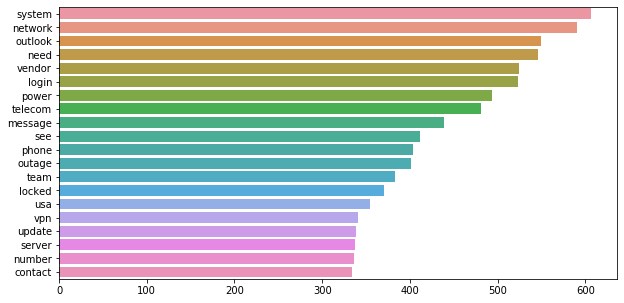

In [0]:
plt.figure(figsize=(10,5))
top_unigrams=get_top_ticketdesc_unigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x)

In [0]:
def get_top_ticketdesc_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

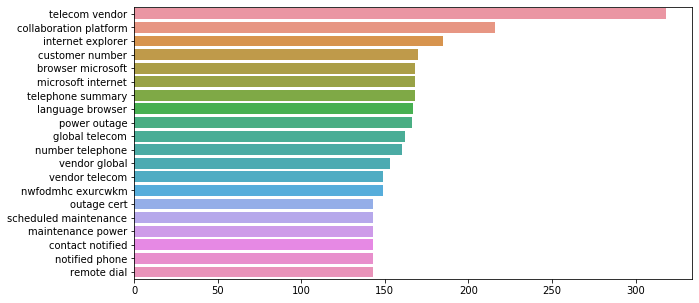

In [0]:
plt.figure(figsize=(10,5))
top_bigrams=get_top_ticketdesc_bigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

In [0]:
def get_top_ticketdesc_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

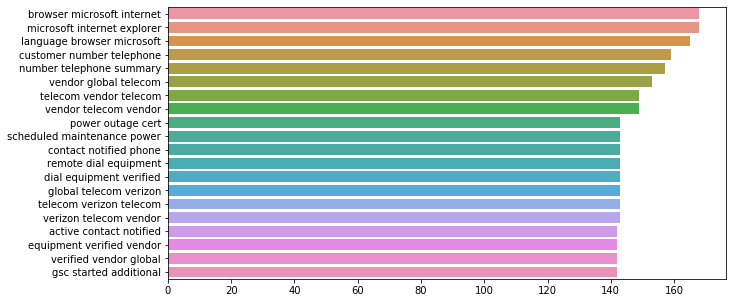

In [0]:
plt.figure(figsize=(10,5))
top_trigrams=get_top_ticketdesc_trigrams(dfTicketngrams['EnglishDescription'])[:20]
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)

#### Create Corpus

In [0]:
def listToString(s):
  str1 = " "
  for ele in s:
    str1 = str1 + " " + ele
  return str1

In [0]:
def create_corpus(df):
    corpus=[]
    for desc in tqdm(df['LemmaString'].astype(str)):
        words=[word.lower() for word in word_tokenize(desc) if((word.isalpha()==1))] # & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [0]:
dfTicketngrams['LemmaString'] = dfTicketngrams['LemmaWords'].apply(lambda x: listToString(x))

corpus=create_corpus(dfTicketngrams)

100%|██████████| 8500/8500 [00:00<00:00, 9873.53it/s]


## Model Building

### Approach 1 ( Classification Approach )
Classification of 75 groups

#### Train and test Split

In [0]:
df1= dfTicketngrams[['LemmaString','Assignment group']]
df1.head()

LemmaString Assignment group
0    login verify detail employee manager check advise caller confirm resolve                   GRP_0          
1    outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind  GRP_0          
2    log vpn eylqgodm ybqkwiam not                                                              GRP_0          
3    hr                                                                                         GRP_0          
4    skype                                                                                      GRP_0

In [0]:
X_train = df1.loc[:6000, 'LemmaString'].values
y_train = df1.loc[:6000, 'Assignment group'].values
X_test = df1.loc[6001:, 'LemmaString'].values
y_test = df1.loc[6001:, 'Assignment group'].values

In [0]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(6001, 9959) (2499, 9959)


#### Model

##### Naive Bayes

In [0]:
clf = MultinomialNB().fit(train_vectors, y_train)

In [0]:
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.49459783913565425


In [0]:
print(predicted[1])

GRP_0


In [0]:
cm = confusion_matrix(y_test, predicted) 
cm

array([[1131,    0,    0, ...,    0,    3,    0],
       [   4,    0,    0, ...,    0,    4,    0],
       [  26,    0,    0, ...,    0,    0,    0],
       ...,
       [   1,    0,    0, ...,    0,    0,    0],
       [ 112,    0,    0, ...,    0,   81,    0],
       [  71,    0,    0, ...,    0,    0,    0]])

##### SVM Model

In [0]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')

In [0]:
SVM.fit(train_vectors ,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
predictions = SVM.predict(test_vectors)
print("SVM Accuracy Score -> ",accuracy_score(predictions, y_test)*100)

SVM Accuracy Score ->  59.343737494997995


In [0]:
Lcm = confusion_matrix(y_test, predictions) 
print(Lcm)

[[1096    0    0 ...    0    3    0]
 [   2    0    0 ...    0    0    0]
 [  16    0    8 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  85    0    0 ...    0   97    0]
 [  64    0    0 ...    0    1    4]]


In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       GRP_0       0.57      0.97      0.72      1134
       GRP_1       0.00      0.00      0.00         9
      GRP_10       0.89      0.31      0.46        26
      GRP_11       0.00      0.00      0.00        13
      GRP_12       0.62      0.39      0.48        94
      GRP_13       0.40      0.39      0.40        41
      GRP_14       0.67      0.37      0.47        38
      GRP_15       0.00      0.00      0.00        12
      GRP_16       0.00      0.00      0.00        18
      GRP_17       0.90      1.00      0.95        19
      GRP_18       0.54      0.28      0.37        25
      GRP_19       0.55      0.09      0.15        68
       GRP_2       0.58      0.44      0.50        64
      GRP_20       0.00      0.00      0.00        13
      GRP_21       0.00      0.00      0.00         8
      GRP_22       0.00      0.00      0.00        12
      GRP_23       0.50      0.29      0.36         7
      GRP_24       0.78    

##### Grid Search CV

In [0]:
params_grid = [{'kernel': ['linear','rbf'], 'C': [10.0,1.0,0.1,0.01]}]

svm_model_pc = GridSearchCV(svm.SVC(probability=True, decision_function_shape='ovr'), params_grid,cv=5,  verbose=1)

svm_model_pc.fit(train_vectors, y_train)

svm_model_pc.score

# View the accuracy score
print('Best score for training data:', svm_model_pc.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model_pc.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model_pc.best_estimator_.kernel,"\n")

final_model_pc = svm_model_pc.best_estimator_

y_pred = final_model_pc.predict(test_vectors)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 26.7min finished


Best score for training data: 0.6025661948376353 

Best C: 1.0 

Best Kernel: linear 



In [0]:
print("Training score for GridSearch SVM: %f" % final_model_pc.score(train_vectors, y_train))
print("Testing score for GridSearch SVM: %f" % final_model_pc.score(test_vectors, y_test))
print("\n")

Training score for GridSearch SVM: 0.768539
Testing score for GridSearch SVM: 0.593437




In [0]:
Lcm = confusion_matrix(y_test, y_pred) 
print(Lcm)

[[1096    0    0 ...    0    3    0]
 [   2    0    0 ...    0    0    0]
 [  16    0    8 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  85    0    0 ...    0   97    0]
 [  64    0    0 ...    0    1    4]]


##### Deep Learning

In [0]:
df1.head()

LemmaString Assignment group
0    login verify detail employee manager check advise caller confirm resolve                   GRP_0          
1    outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind  GRP_0          
2    log vpn eylqgodm ybqkwiam not                                                              GRP_0          
3    hr                                                                                         GRP_0          
4    skype                                                                                      GRP_0

In [0]:
## TOTAL NUMBER OF WORDS USED IN EACH HEADLINE
df1['nb_words'] = df1.LemmaString.apply(lambda x: len(x.split()))

## TOTAL NUMBER OF UNIQUE WORDS USED IN EACH HEADLINE
df1['nb_unique_words'] = df1.LemmaString.apply(lambda x: len(set(x.split())))

## TOTAL NUMBER OF CHARACTERS USED IN EACH HEADLINE
df1['nb_char'] = df1.LemmaString.apply(lambda x: len(x))

In [0]:
df1.LemmaString

0         login verify detail employee manager check advise caller confirm resolve                 
1         outlook hmjdrvpb komuaywn team meeting skype appear calendar somebody advise correct kind
2         log vpn eylqgodm ybqkwiam not                                                            
3         hr                                                                                       
4         skype                                                                                    
         ...                                                                                       
8495      email come mail avglmrts vhqmtiua receive advise                                         
8496      telephony software                                                                       
8497      window tifpdchb pedxruyf                                                                 
8498      machine funcionando utility finish drawer adjustment setting network                     


In [0]:
maxlen = df1['nb_words'].max()
print(maxlen)

395


In [0]:
max_features = 10000
embedding_size = 50

In [0]:
tokenizer_obj=Tokenizer(num_words=max_features)
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

In [0]:
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer_obj.fit_on_texts(corpus)

In [0]:
X = tokenizer_obj.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxlen)

df1['Assignment group'].astype(str)
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in column 'species'. 
y = df1['Assignment group']= label_encoder.fit_transform(df1['Assignment group']) 
y = to_categorical(y, num_classes= 74)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

Number of Samples: 8500
Number of Labels:  8500


###### Get the Vocabulary size

In [0]:
word_index = tokenizer_obj.word_index
num_words = len(word_index)+1
print(num_words)

12743


###### Word Embedding

In [0]:
embeddings = {}
for o in open(project_path+'/glove.6B.50d.txt','r'):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

###### Create a weight matrix for words in training docs

In [0]:
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer_obj.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
     embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

###### Create and Compile your Model

###### LSTM

In [0]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          637150    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                19018     
Total params: 839,464
Trainable params: 839,464
Non-trainable params: 0
_________________________________________________________________


###### Fit your model


In [0]:
from keras.callbacks import EarlyStopping
history = model.fit(X,y,batch_size=100,epochs=50,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6800 samples, validate on 1700 samples
Epoch 1/50
6800/6800 [==============================] - 67s 10ms/step - loss: 2.5900 - acc: 0.4703 - val_loss: 2.4858 - val_acc: 0.4612
Epoch 2/50
6800/6800 [==============================] - 65s 10ms/step - loss: 2.2167 - acc: 0.4979 - val_loss: 2.2757 - val_acc: 0.4882
Epoch 3/50
6800/6800 [==============================] - 69s 10ms/step - loss: 2.0093 - acc: 0.5312 - val_loss: 2.1101 - val_acc: 0.5012
Epoch 4/50
6800/6800 [==============================] - 67s 10ms/step - loss: 1.8476 - acc: 0.5578 - val_loss: 2.0127 - val_acc: 0.5112
Epoch 5/50
6800/6800 [==============================] - 66s 10ms/step - loss: 1.7172 - acc: 0.5856 - val_loss: 1.9117 - val_acc: 0.5529
Epoch 6/50
6800/6800 [==============================] - 66s 10ms/step - loss: 1.5995 - acc: 0.6028 - val_loss: 1.8476 - val_acc: 0.5594
Epoch 7/50
6800/6800 [==================

###### Plot Graph

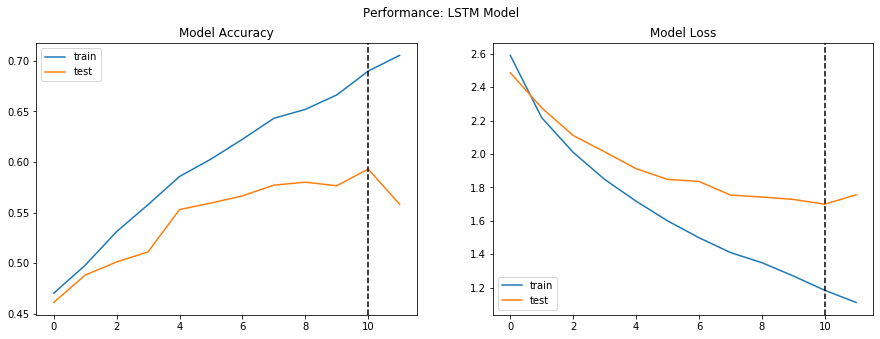

In [0]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance: LSTM Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

###### GRU

In [0]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          637150    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         137472    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                19018     
Total params: 793,640
Trainable params: 793,640
Non-trainable params: 0
_________________________________________________________________


###### Fit your model


In [0]:
from keras.callbacks import EarlyStopping
history = model.fit(X,y,batch_size=100,epochs=50,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 6800 samples, validate on 1700 samples
Epoch 1/50
6800/6800 [==============================] - 55s 8ms/step - loss: 2.5693 - acc: 0.4762 - val_loss: 2.3573 - val_acc: 0.4676
Epoch 2/50
6800/6800 [==============================] - 53s 8ms/step - loss: 2.1007 - acc: 0.5141 - val_loss: 2.1627 - val_acc: 0.4824
Epoch 3/50
6800/6800 [==============================] - 53s 8ms/step - loss: 1.9015 - acc: 0.5560 - val_loss: 2.0424 - val_acc: 0.5124
Epoch 4/50
6800/6800 [==============================] - 54s 8ms/step - loss: 1.7506 - acc: 0.5832 - val_loss: 1.9270 - val_acc: 0.5512
Epoch 5/50
6800/6800 [==============================] - 57s 8ms/step - loss: 1.6320 - acc: 0.5984 - val_loss: 1.8494 - val_acc: 0.5635
Epoch 6/50
6800/6800 [==============================] - 55s 8ms/step - loss: 1.5165 - acc: 0.6181 - val_loss: 1.7951 - val_acc: 0.5576
Epoch 7/50
6800/6800 [==============================] - 53s 8ms/step - loss: 1.4182 - acc: 0.6350 - val_loss: 1.7519 - val_acc: 0.5688
Epoch 8

###### Plot Graph

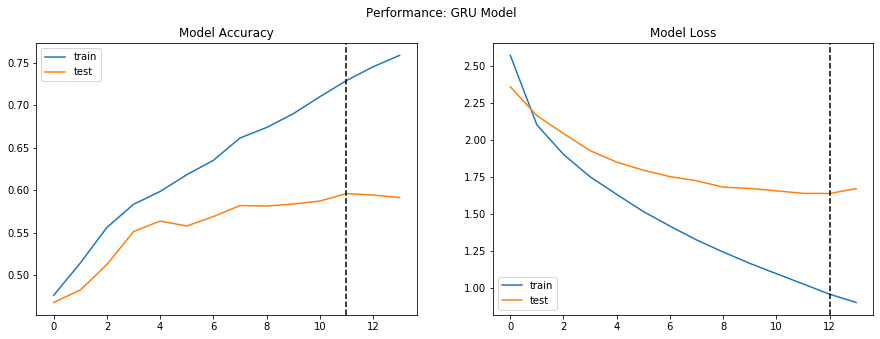

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance: GRU Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

#### Summary of Approach 1:

Currently, we have used Classical Machine Learning Model such as Naive Bayes, SVM, GridSearchCV on SVM model, LSTM and GRU models for said text classification.  
As can be seen, the accuracy along with precision and recall for different classes is very low. <br>
The reason for this low accuracy is mentioned below:<br>

         Highly Imbalanced Dataset
         Proper Hyperparameter tuning may be required
         Proper Model selection may be required


We may try below steps to fine tune our model during our next Milestone.
      
      1. Fine tuning existing model with hyper parameters.
      2. Handling imbalance of classes if accuracy with step 1 is not achieved.
      3. Using a different approach altogether. Since the base of the problem talks about L1/L2/L3 groups, our first approach would be to divide the tickets to a larger group of L1/L2/L3 and then break it down into individual groups as given in the dataset.

### Approach 2- Hyperparameter tuning on Deep Learning LSTM Model

As we can see, we are not seeing good results from above approach. We will perform Hyparameter tuning on our models.

In [0]:
batch_size = 32
epochs = 25

#### 3 A. Stacked LSTM with 64 Neurons

In [0]:
# Define model for stacked LSTM with 64 units

def stacked_lstm64(X, y, num_class):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

  main_input = Input(shape=(maxlen,))

  #em = Embedding(max_features, 100, input_length=maxlen) (main_input)
  em = Embedding(len(wordvectors.syn0), 100, weights = [wordvectors.vectors]) (main_input)

  lstm_out1 = LSTM(64, return_sequences = True)(em)
  lstm_out2 = LSTM(64)(lstm_out1)

  x = Dropout(0.4)(lstm_out2)

  main_output = Dense(num_class, activation = 'softmax')(x)

  model = Model(inputs = main_input, outputs = main_output)

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  print('Model summary for stacked LSTM model with 64 units: \n', model.summary())

  #Fit the model
  model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight = 'auto') 

  # Print model for train and test data
  print('Trainig set accuracy: ', model.evaluate(X_train, y_train))
  print('Test set accuracy: ', model.evaluate(X_test, y_test))

  # Prediction on Test data
  y_pred = model.predict(X_test)
  y_pred_rd = np.round(y_pred)

  #Print Classification matrix
  print(classification_report(y_test, y_pred_rd))

  return y_pred_rd

In [0]:
y_pred64_rd = stacked_lstm64(X_train, y_train, num_class) # Run the stacked LSTM model with 64 units and print model summary along with classification report for the predicted target value 











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          2700      
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 64)           42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                4810     

#### 3 B. Stacked LSTM with 128 Neurons

In [0]:
# Define model for stacked LSTM with 128 units

def stacked_lstm(X, y, num_class):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)
  main_input = Input(shape=(maxlen,))

  em = Embedding(max_features, 100, input_length=maxlen) (main_input)

  lstm_out1 = LSTM(128, return_sequences = True)(em)
  lstm_out2 = LSTM(128)(lstm_out1)

  x = Dropout(0.4)(lstm_out2)

  main_output = Dense(num_class, activation = 'softmax')(x)

  model = Model(inputs = main_input, outputs = main_output)

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  print('Model summary for stacked LSTM model: \n', model.summary())

  #Fit the model
  model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight = 'auto') #callbacks=[EarlyStopping(verbose=True, patience=5, monitor='acc')],

  # Print accuracy of the model on train and test data
  print('Trainig set accuracy: ', model.evaluate(X_train, y_train))
  print('Test set accuracy: ', model.evaluate(X_test, y_test))

  # Prediction on Test data
  y_pred = model.predict(X_test)
  y_pred_rd = np.round(y_pred)

  #Print Classification matrix
  print(classification_report(y_test, y_pred_rd))

  return y_pred_rd

In [0]:
y_pred_rd = stacked_lstm(X_train, y_train, num_class) # Run the stacked LSTM model with 128 units and print model summary along with classification report for the predicted target value 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                9546      
Total params: 1,258,378
Trainable params: 1,258,378
Non-trainable params: 0
_________________________________________________

#### 3 C. Stacked LSTM with 128 Neurons and L2 regularization

In [0]:
# Define model for stacked LSTM with 128 units and L2 regularization 

def stacked_lstm_l2(X, y, num_class):
    main_input_l2 = Input(shape=(maxlen,))

    em_l2 = Embedding(max_features, 100, input_length=maxlen) (main_input_l2)


    lstm_out1_l2 = LSTM(128, return_sequences = True)(em_l2)
    lstm_out2_l2 = LSTM(128)(lstm_out1_l2)

    x_l2 = Dropout(0.4)(lstm_out2_l2)

    main_output_l2 = Dense(num_class, activation = 'softmax', kernel_regularizer=l2(0.01))(x_l2)

    model_l2 = Model(inputs = main_input_l2, outputs = main_output_l2)

    # compile the model
    model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print('Model summary for stacked LSTM model with L2 regularization: \n', model_l2.summary())

    #Fit the model
    model_l2.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight = 'auto') #callbacks=[EarlyStopping(verbose=True, patience=5, monitor='acc')],

    print('Trainig set accuracy: ', model_l2.evaluate(X_train, y_train))
    print('Test set accuracy: ', model_l2.evaluate(X_test, y_test))

    # Prediction on Test data
    y_pred_l2 = model_l2.predict(X_test)
    y_pred_l2_rd = np.round(y_pred_l2)

    #Print Classification matrix
    print(classification_report(y_test, y_pred_l2_rd))

    return y_pred_l2_rd

In [0]:
y_pred_l2_rd = stacked_lstm_l2(X_train, y_train, num_class) # Run the stacked LSTM model with 128 units and L2 regularization and print model summary along with classification report for the predicted target value 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 150, 128)          117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 74)                9546      
Total params: 1,258,378
Trainable params: 1,258,378
Non-trainable params: 0
_________________________________________________

#### ROC curve:

In [0]:
y_test_inv = np.argmax(y_test, axis=-1) # Inverse transform of y_test for use in ROC curve

In [0]:
y_pred64_inv = np.argmax(y_pred64_rd, axis = -1) # Inverse transform of y_pred of stacked lstm model with 64 units for use in ROC curve

In [0]:
y64_fpr, y64_tpr,_x = roc_curve(y_test_inv, y_pred64_inv, pos_label=1)

In [0]:
y_pred_inv = np.argmax(y_pred_rd, axis = -1) # Inverse transform of y_pred of stacked lstm model with 128 units for use in ROC curve

In [0]:
y_fpr, y_tpr, _ = roc_curve(y_test_inv, y_pred_inv, pos_label=1)

In [0]:
y_pred_l2_inv = np.argmax(y_pred_l2_rd, axis = -1) # Inverse transform of y_pred of stacked lstm model with 128 units and L2 regularization for use in ROC curve

In [0]:
y_l2_fpr, y_l2_tpr, _l2 = roc_curve(y_test_inv, y_pred_l2_inv, pos_label=1)

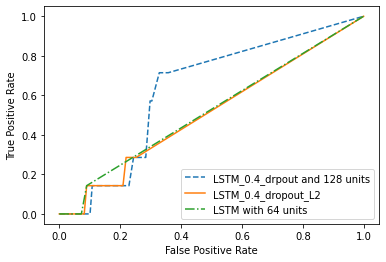

In [0]:
plt.plot(y_fpr, y_tpr, linestyle='--', label='LSTM_0.4_drpout and 128 units')
plt.plot(y_l2_fpr, y_l2_tpr, linestyle='solid', label='LSTM_0.4_dropout_L2')
plt.plot(y64_fpr, y64_tpr, linestyle='dashdot', label='LSTM with 64 units')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Learnings from the approach

•	We observed that by means of tweaking the various Hyperparameters in LSTM Model, maximum validation accuracy we reached is around 60 percent. 

•	Changing LSTM neurons from 64 to 128 has resulted in decrease of validation accuracy but has shown significant increase in train accuracy, which clearly the case of overfitting.

•	We tried increasing the Dropout, which did not have impact on improving the validation accuracy.

•	To reduce the overfitting, we tried to include L2 regularization parameter in the model, which as expected decreased the accuracy of the model as model is not generalizing well on unseen data.

•	Though we were able to achieve an accuracy of 85 percent on train data, we are not getting above 60% on the validation set. <br>
We can confidently say the main reasons could be the highly imbalanced data. 

•	 There are around more than 35 groups which holds less than 2% (1 incident per group) of the total distribution where GRP_0 has hold nearly 47% of the distribution. We need to handle this distribution in order to get better results.
We have seen how our RNN models are classifying the data. Now we are curious to see how classical machine learning models treat this kind of data. Models like SVM and Naïve Bayes prove to be quite robust in classification problems. As our next approach we will build these models on our preprocessed data. 


### Approach 3-Clustering method

In 3rd Approach we will merge the groups using Clustering method and explore some more insights on our dataset.<br>
<b>Please Note:</b> This is not Modelling Approach rather it is an extension to our EDA.

We have understood that our data is highly imbalanced where one groups is holding mode than 46% of the distribution and on the other hand many groups only have single ticket entry. To understand our dataset better we are building clusters to identify groups having similar patterns and if need be can be grouped together to make data less sparse.  <br>


In [0]:
def prep_data4Modelling(data):
  
  print("Converting all text columns datatype to String type:")
  data['Short description']=data['Short description'].apply(str)
  data['Description'] = data['Description'].apply(str)
  data['Caller'] = data['Caller'].apply(str)
  
  print("Removing Caller Names from the text:")
  caller_list = data["Caller"].str.split(" ", n = 1, expand = True)  
  caller_fname = caller_list[0]
  caller_lname = caller_list[1]  
  caller_fname_list = caller_fname.to_list()
  caller_lname_list = caller_lname.to_list()
  
  data.Description = data.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_fname_list]))
  data.Description = data.Description.apply(lambda x: ' '.join([word for word in x.split() if word not in caller_lname_list]))
  
  print("Merging Description and short Description column:")
  #Let's combine all 3 independent attribute to 1
  data['Complete_Description'] = data['Short description'].str.cat(data['Description'],sep=" ")
  print("Removing unnecessary spaces:")
  data.Complete_Description = data.Complete_Description.apply(lambda x: x.strip())
  
  data['Complete_Description'] = (data['Complete_Description'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  
  print("Removing the rest of the columns from dataframe:")
  data.drop(['Short description','Description','Caller'], axis=1, inplace=True)

  print("Performing Language Detection:")
  translator = Translator()
  languages = googletrans.LANGUAGES

  DetectorFactory.seed = 0

  data['Language'] = data['Complete_Description'].apply(lambda x: detect(x))
  data['Language'] = data['Language'].apply(lambda x: languages[x].upper())
  
  print("Data Preprocessing Starts Here:")
  data = textPreprocessing(data,'Complete_Description')
  print("Data Preprocessing Ends Now:")

  #print(data.head())

  #print("Validation if all texts converted are english or not:")
  #data['NewLanguage'] = data['EnglishDescription'].apply(lambda x: detect(x))
  #print("Keeping only those texts which are translated to English by the Googletrans:")
  #data = data[data['NewLanguage']=='en']

  print("Tokenizing the data:")
  data['Tokens'] = data['EnglishDescription'].apply(lambda x: tokenizeText(x))
  
  print("Cleaning the tokens by removing stop words:")
  cleanTokens = []
  for col_desc in range(len(data.Tokens)):
    str_token = data.Tokens[col_desc]
    cleanTokens.append([w for w in str_token if w not in stop_words] )
  data['Tokens'] = cleanTokens
  
  print("Lemmatizing the tokenized words:")
  data['LemmaWords'] = data['Tokens'].apply(lambda x: lemmatizeText(x))
  print("Removing Duplicate words from the lemmatized words:")
  data['LemmaWords'] = data['LemmaWords'].apply(lambda x: RemovDupWordTokens(x))
  print("Converting the lemmatized tokens to String:")
  data['LemmaString'] = data['LemmaWords'].apply(lambda x: listToString(x))

  print("Now our all Pre-Processing steps are completed and final dataframe is created.")
  return data.head(5)

In [0]:
df = pd.read_excel('/content/drive/My Drive/GL AIML/Capstone/Input Data Synthetic (created but not used in our project).xlsx')

In [0]:
prep_data4Modelling(df)

Converting all text columns datatype to String type:
Removing Caller Names from the text:
Merging Description and short Description column:
Removing unnecessary spaces:
Removing the rest of the columns from dataframe:
Performing Language Detection:
Data Preprocessing Starts Here:
updating all cases to lower cases:
Translating Non English to English:
removing data using regular expression List:
removing stopwords:
removing top 20 Most common words:
removing punctuations:
Data Preprocessing Ends Now:
Tokenizing the data:
Cleaning the tokens by removing stop words:
Lemmatizing the tokenized words:
Removing Duplicate words from the lemmatized words:
Converting the lemmatized tokens to String:
Now our all Pre-Processing steps are completed and final dataframe is created.


Assignment group  ...                                        LemmaString
0            GRP_0  ...    login verified details employee manager chec...
1            GRP_0  ...    outlook hmjdrvpb komuaywn team meetings skyp...
2            GRP_0  ...                      log vpn eylqgodm ybqkwiam not
3            GRP_0  ...                                                 hr
4            GRP_0  ...                                              skype

[5 rows x 7 columns]

In [0]:
final_df = df[['LemmaString','Assignment group']].copy()

In [0]:
final_df.head()

LemmaString Assignment group
0    login verified details employee manager chec...            GRP_0
1    outlook hmjdrvpb komuaywn team meetings skyp...            GRP_0
2                      log vpn eylqgodm ybqkwiam not            GRP_0
3                                                 hr            GRP_0
4                                              skype            GRP_0

In [0]:
df1 = final_df.copy()

df1['New group'] = LabelEncoder().fit_transform(df1['Assignment group'])
df1.head()

LemmaString  ... New group
0    login verified details employee manager chec...  ...         0
1    outlook hmjdrvpb komuaywn team meetings skyp...  ...         0
2                      log vpn eylqgodm ybqkwiam not  ...         0
3                                                 hr  ...         0
4                                              skype  ...         0

[5 rows x 3 columns]

In [0]:
df2 = df1[['New group','LemmaString']].copy()

In [0]:
df2.head()

New group                                        LemmaString
0          0    login verified details employee manager chec...
1          0    outlook hmjdrvpb komuaywn team meetings skyp...
2          0                      log vpn eylqgodm ybqkwiam not
3          0                                                 hr
4          0                                              skype

In [0]:
X = df2['LemmaString'].values

vectorizer = TfidfVectorizer()
X_vectors = vectorizer.fit_transform(X)
print(X_vectors.shape)

(8500, 14279)


In [0]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,15):
    km = KMeans(n_clusters=i, random_state=0).fit(X_vectors)
    preds = km.predict(X_vectors)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_vectors)))
    km_scores.append(-km.score(X_vectors))
    
    silhouette = silhouette_score(X_vectors,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_vectors.toarray(),preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    print("-"*100)

Score for number of cluster(s) 2: -7699.029694459533
Silhouette score for number of cluster(s) 2: 0.03824453198554169
Davies Bouldin score for number of cluster(s) 2: 3.2041028035086048
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -7594.33101813118
Silhouette score for number of cluster(s) 3: 0.043912385955778656
Davies Bouldin score for number of cluster(s) 3: 3.0345585502552552
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -7492.214319989217
Silhouette score for number of cluster(s) 4: 0.04979278227528991
Davies Bouldin score for number of cluster(s) 4: 2.5510831688599294
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 5: -7394.319103964547
Silhouette score for number of cluster(s) 5: 0.05747786214787084
Davies Bouldin score 

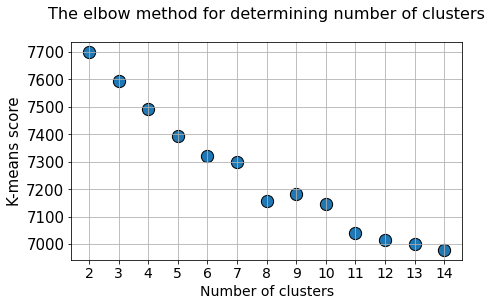

In [0]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,15)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

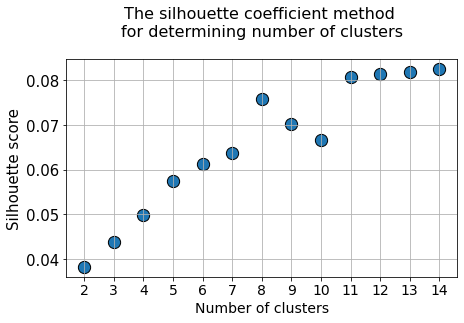

In [0]:

plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,15)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

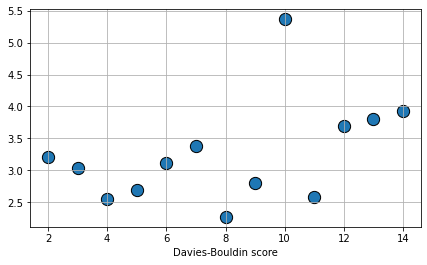

In [0]:
plt.figure(figsize=(7,4))
plt.scatter(x=[i for i in range(2,15)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

In [0]:
km_8 = KMeans(n_clusters=8, random_state=0).fit(X_vectors)
preds_8 = km_8.predict(X_vectors)

In [0]:
labels = km_8.labels_

In [0]:
df2['clusters'] = labels

In [0]:
df2.head()

New group                                        LemmaString  clusters
0          0    login verified details employee manager chec...         4
1          0    outlook hmjdrvpb komuaywn team meetings skyp...         1
2          0                      log vpn eylqgodm ybqkwiam not         1
3          0                                                 hr         1
4          0                                              skype         1

In [0]:
df.head()

Assignment group  ...                                        LemmaString
0            GRP_0  ...    login verified details employee manager chec...
1            GRP_0  ...    outlook hmjdrvpb komuaywn team meetings skyp...
2            GRP_0  ...                      log vpn eylqgodm ybqkwiam not
3            GRP_0  ...                                                 hr
4            GRP_0  ...                                              skype

[5 rows x 7 columns]

In [0]:
df2['Assignment_group'] = df['Assignment group']

In [0]:
df2.head()

New group  ... Assignment_group
0          0  ...            GRP_0
1          0  ...            GRP_0
2          0  ...            GRP_0
3          0  ...            GRP_0
4          0  ...            GRP_0

[5 rows x 4 columns]

In [0]:
df2[df2['Assignment_group']=='GRP_0']['clusters'].unique()

array([4, 1, 5, 3, 6, 2])

In [0]:
df2[df2['Assignment_group']=='GRP_1']['clusters'].unique()

array([1, 0])

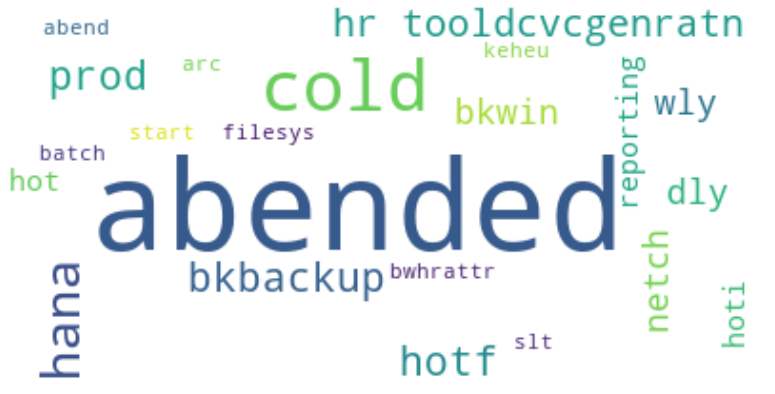

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==0].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

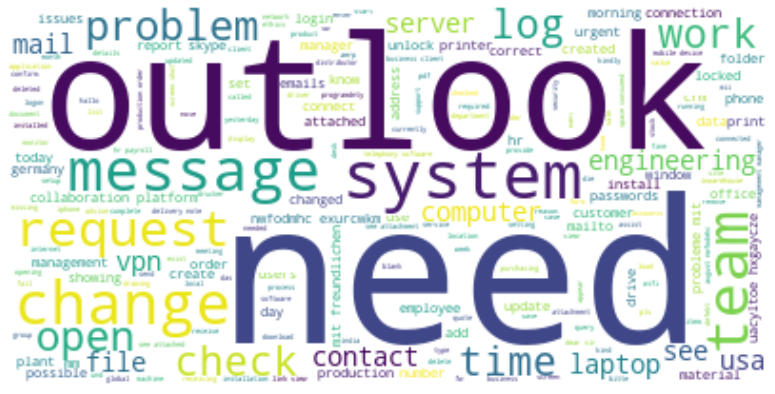

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==1].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

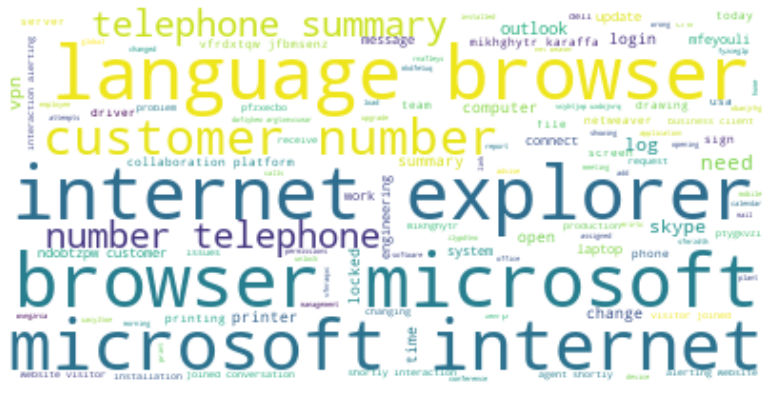

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==2].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

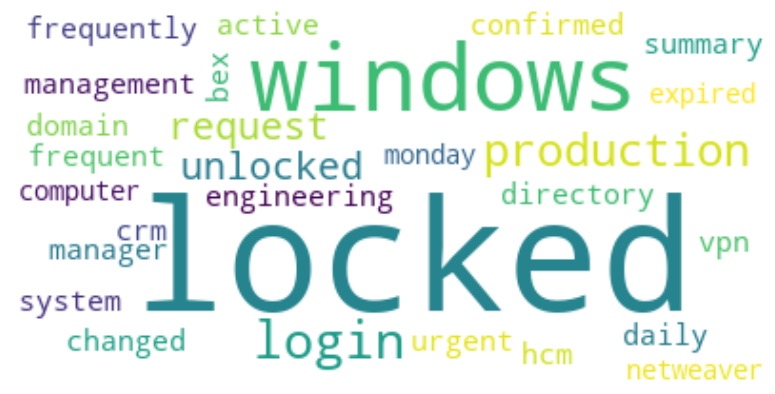

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==3].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

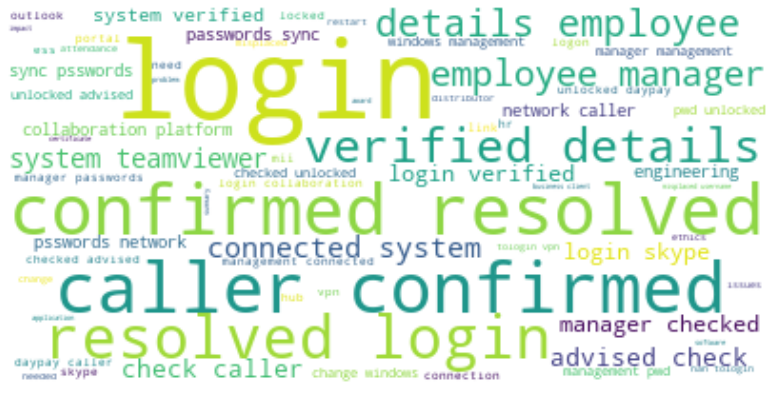

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==4].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

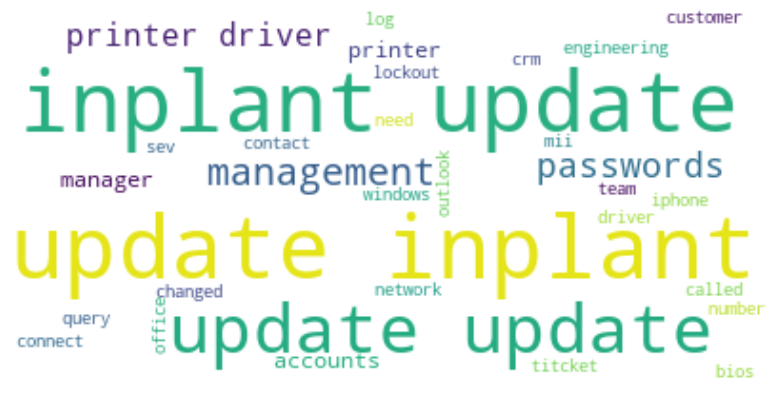

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==5].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

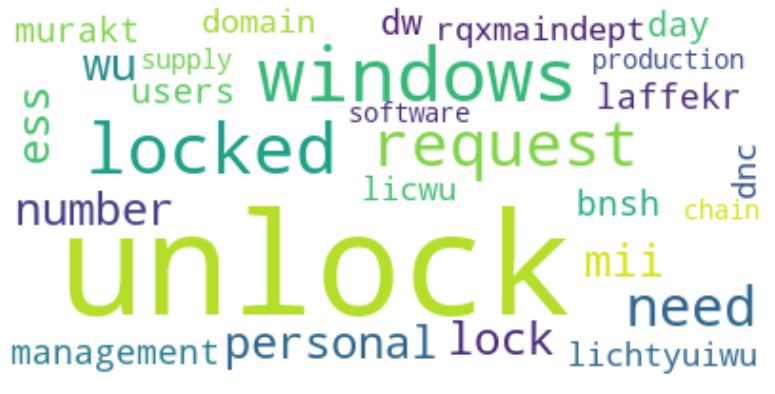

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==6].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

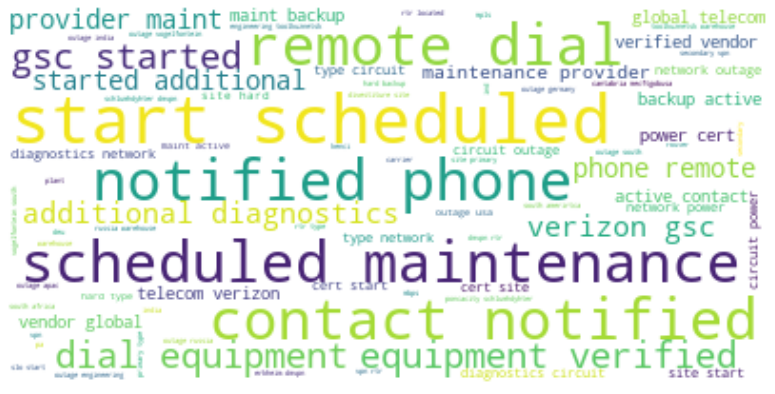

In [0]:
#Word Cloud
text = ' '.join(map(str, df2[df2['clusters']==7].LemmaString))

wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#####Observations:  
We could see very interesting insights from these 8 clusters. The issues in these 8 clusters seems to be as below:<br>
0: Job Abends, backup issue<br>
1: Outlook, message, mail, vpn issue<br>
2: Internet Explorer, Browser issues<br>
3: Windows login, locking issues<br>
4: Employee login, teamviewer, password related issues<br>
5: inplant, printer, windows update related issues<br>
6: windows software request, locking issues<br>
7: Scheduled maintenance, equipment related issue<br>


Exporting the Extracted Cluster Label Data and Complete Proprocessed data to Excel File for future use

In [0]:
from pandas import ExcelWriter

writer1 = ExcelWriter('Complete_data2.xlsx')
df.to_excel(writer1,'Sheet1', index=False, )
writer1.save()

writer2 = ExcelWriter('Cluster_labels2.xlsx')
df2.to_excel(writer2,'Sheet1', index=False, )
writer2.save()

In [0]:
df2.head()

New group  ... Assignment_group
0          0  ...            GRP_0
1          0  ...            GRP_0
2          0  ...            GRP_0
3          0  ...            GRP_0
4          0  ...            GRP_0

[5 rows x 4 columns]

#### Model Building

In [0]:
max_features = 10000
embedding_size = 50

In [0]:
def create_corpus(df):
    corpus=[]
    for desc in tqdm(df['LemmaString'].astype(str)):
        words=[word.lower() for word in word_tokenize(desc) if((word.isalpha()==1))] # & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [0]:
def create_inputvector(data,max_features,embedding_size,target):
  corpus = create_corpus(data)

  nb_words = []
  for i in range(len(data['LemmaString'])):
    nb_words.append(len(data['LemmaString'].iloc[i].split()))

  data['nb_words'] = nb_words
  print(data.columns)
  maxlen = max(data['nb_words'])

  tokenizer_obj=Tokenizer(num_words=max_features)
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)

  word_index = tokenizer_obj.word_index
  num_words = len(word_index)+1

  X = tokenizer_obj.texts_to_sequences(corpus)
  X = pad_sequences(X, maxlen = maxlen)
  y1 = data[target]
  y = to_categorical(y1, num_classes=8)
  return X,y,y1,maxlen,num_words

In [0]:
X,y,y1,maxlen,num_words=create_inputvector(data=df2,max_features=max_features,embedding_size=embedding_size,target='clusters')

100%|██████████| 8500/8500 [00:01<00:00, 8394.22it/s]


Index(['New group', 'LemmaString', 'clusters', 'Assignment_group', 'nb_words'], dtype='object')


In [0]:
batch_size = 100
epochs = 50

In [0]:
def LSTM_model(maxlen,batch_size,epochs):
  main_input = Input(shape=(maxlen,))
  em = Embedding(max_features, 100, input_length=maxlen) (main_input)

  lstm_out1 = LSTM(128, return_sequences = True)(em)
  lstm_out2 = LSTM(128)(lstm_out1)

  x = Dropout(0.2)(lstm_out2)

  main_output = Dense(8, activation = 'softmax')(x)

  model = Model(inputs = main_input, outputs = main_output)
  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                               save_weights_only=True, mode="min", period=1)
  stop = EarlyStopping(monitor="loss", patience=5, mode="min")
  reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
  print(model.summary())
  return model,checkpoint,stop,reduce_lr


In [0]:
def plot_graph(history):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
  fig.suptitle("Performance: GRU Model")
  ax1.plot(history.history['acc'])
  ax1.plot(history.history['val_acc'])
  cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
  ax1.axvline(x=cut, color='k', linestyle='--')
  ax1.set_title("Model Accuracy")
  ax1.legend(['train', 'test'])

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
  ax2.axvline(x=cut, color='k', linestyle='--')
  ax2.set_title("Model Loss")
  ax2.legend(['train', 'test'])

##### Model 1: Vanilla LSTM

In [0]:
model1,checkpoint1,stop1,reduce_lr1 = LSTM_model(maxlen=maxlen,batch_size=batch_size,epochs=epochs)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 415)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 415, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 415, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Tota

In [0]:
history1 = model1.fit(X, y, validation_split= 0.2, batch_size=batch_size, epochs=50, callbacks=[stop1], class_weight = 'auto')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6800 samples, validate on 1700 samples
Epoch 1/50





6800/6800 [==============================] - 167s 25ms/step - loss: 0.6808 - acc: 0.8684 - val_loss: 0.9454 - val_acc: 0.8388
Epoch 2/50
6800/6800 [==============================] - 164s 24ms/step - loss: 0.3590 - acc: 0.9143 - val_loss: 0.7745 - val_acc: 0.8447
Epoch 3/50
6800/6800 [==============================] - 165s 24ms/step - loss: 0.1682 - acc: 0.9418 - val_loss: 0.7686 - val_acc: 0.8941
Epoch 4/50
6800/6800 [==============================] - 162s 24ms/step - loss: 0.0783 - acc: 0.9765 - val_loss: 0.7969 - val_acc: 0.8988
Epoch 5/50
6800/6800 [==============================] - 164s 24ms/step - loss: 0.0425 - acc: 0.9907 - val_loss: 0.6751 - val_acc: 0.9047
Epoch 6/50
6800/6800 [==============================] - 166s 24ms/step - loss: 0.0252 - acc: 0.9951 - val_loss: 0.7842 - val_acc: 0.9059
Epoch 7/50
6800/6800 [======

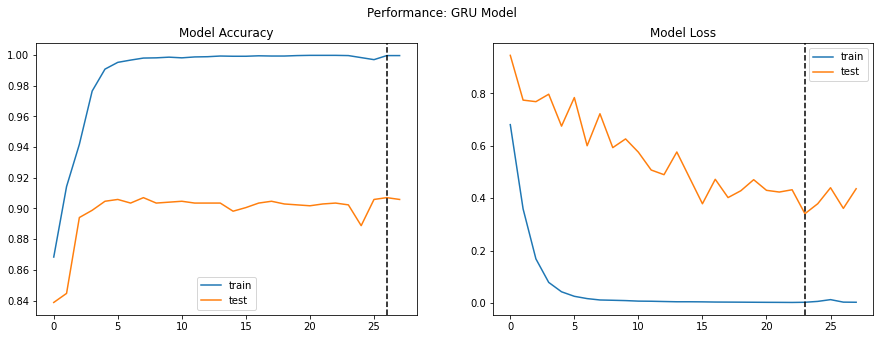

In [0]:
plot_graph(history1)

##### Model 2: LSTM with Stratified K Fold

In [0]:
skf = StratifiedKFold(n_splits=5,random_state=24, shuffle=True)
models, measures = [], []
for index, (train_indices, val_indices) in enumerate(skf.split(X, y1)):
   ## Extract Kfold
  X_train_sfk, X_test_sfk = X[train_indices], X[val_indices]
  y_train_sfk, y_test_sfk = y1[train_indices], y1[val_indices]

In [0]:
y_train_sfk = to_categorical(y_train_sfk, num_classes= 8)

In [0]:
y_test_sfk = to_categorical(y_test_sfk,num_classes=8)

In [0]:
model2,checkpoint2,stop2,reduce_lr2 = LSTM_model(maxlen=maxlen,batch_size=batch_size,epochs=epochs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 415)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 415, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 415, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 1,249,864
Trainable params: 1,249,864
Non-trainable params: 0
_________________________________________________

In [0]:
history2 = model2.fit(X_train_sfk, y_train_sfk, validation_data=(X_test_sfk,y_test_sfk), batch_size=batch_size, epochs=50, callbacks=[stop2,reduce_lr2]) #, class_weight = 'auto')

Train on 6800 samples, validate on 1700 samples
Epoch 1/50
6800/6800 [==============================] - 162s 24ms/step - loss: 0.7580 - acc: 0.8581 - val_loss: 0.4856 - val_acc: 0.8971
Epoch 2/50
6800/6800 [==============================] - 161s 24ms/step - loss: 0.3923 - acc: 0.8997 - val_loss: 0.2640 - val_acc: 0.9194
Epoch 3/50
6800/6800 [==============================] - 160s 23ms/step - loss: 0.1987 - acc: 0.9321 - val_loss: 0.2012 - val_acc: 0.9341
Epoch 4/50
6800/6800 [==============================] - 157s 23ms/step - loss: 0.2779 - acc: 0.9101 - val_loss: 0.2108 - val_acc: 0.9194
Epoch 5/50
6800/6800 [==============================] - 159s 23ms/step - loss: 0.1526 - acc: 0.9500 - val_loss: 0.1513 - val_acc: 0.9465
Epoch 6/50
6800/6800 [==============================] - 157s 23ms/step - loss: 0.1027 - acc: 0.9697 - val_loss: 0.1192 - val_acc: 0.9671
Epoch 7/50
6800/6800 [==============================] - 159s 23ms/step - loss: 0.0767 - acc: 0.9826 - val_loss: 0.1056 - val_acc: 

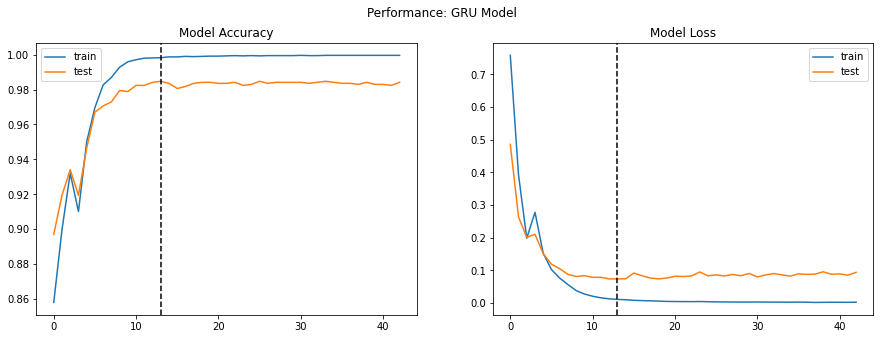

In [0]:
plot_graph(history2)

##### Summary: 
Even though the Accuracy came good for all 8 clusters.
When we tried to train the model on individual clusters to predict ground truth labels(Grp_0, Grp_1.. Grp_73 etc), accuracy came very low.
<br>
As we had similar class imbalance issue in few clusters.
<br>
So, we plan to oversample our minority classes so as to correct the imbalance problem.

### Approach 4 - L12 and L3 Approach

L12 and L3 Approach 

Revisiting our problem description, it describes the current situation as:  
“Currently the incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams). This team will review the incidents for right ticket categorization, priorities and then carry out initial diagnosis to see if they can resolve. Around 54% of the incidents are resolved by L1 / L2 teams. Incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams)”<br><br>
One possible inference we could draw by relating the statement to the dataset is that few of labeled groups which holds the maximum of the data distribution (54%) belong to L1/L2 teams and rest belong to the functional teams i.e. L3 teams. <br>
This also justifies the data distribution we have as GRP_0 alone holds 46% of the distribution and there are only 8 groups which holds count of 150 or more tickets so they might represent L1/L2 teams and many groups have only 1 or 2 entries belong to L3 teams. <br>
<b>Approach:</b><br>

As our next approach we will be building a two-stage classification model. At stage 1, ticket will be classified as one to the two groups i.e. L12 and L3. At the later stage, depending on the classified group, its actual groups will be predicted from one of 74 given group label.   

 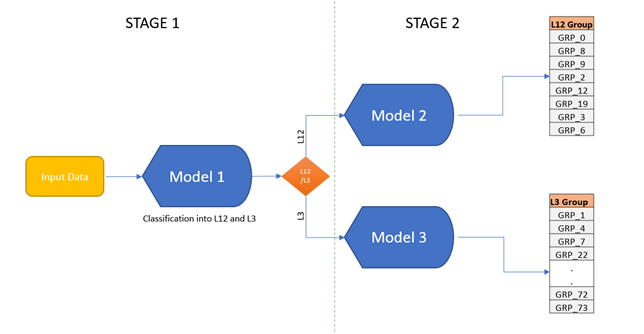
<br><br>
<b>Description of the model</b>

Design of the solution is such that the model first learns how to classify the data into two sub groups and further in the next step it classifies it into final respective target subset groups. The steps as follows:<br>
1)	Assigning L12 and L3 groups: First we are adding new column named “L12Grp” to our preprocessed data which will hold binary value of whether the data belongs to L12 group (value 0) or L3(value 1) according to the defined threshold.  
Threshold: As a threshold, we have kept 150 as the count. Groups having entries more than 150 belong to L12 dataset (L1/L2 teams) and rest belong to the L3 dataset (L3 Teams).<br>

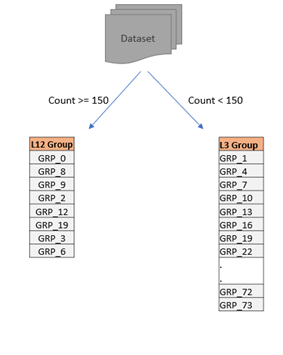

2)	MODEL STAGE 1: For our stage 1 model we will be training the data keeping “L12Grp” as the target variable and description as input variable. We will be trying two models at this stage one using classical machine learning model Random Forest and one Deep learning RNN model of LSTM. 

This model will do binary classification and label the data into 0 (L12) or 1(L3).   <br>

3)	MODEL STAGE 2: For our stage 2 model, first we will be filtering our dataset into two subsets based on the “L12Grp”. This will result in two separate datasets for the L12 and L3 sub groups and we will build two separate models for each.  <br>
This model will do multiclass classification from the subset of groups they have. 


In [0]:
L12 = ['GRP_0', 'GRP_8', 'GRP_9', 'GRP_2', 'GRP_12', 'GRP_19', 'GRP_3', 'GRP_6']

L3 = [ 'GRP_1', 'GRP_4', 'GRP_5', 'GRP_7', 'GRP_10', 'GRP_11',  'GRP_13', 'GRP_14', 'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 
       'GRP_20', 'GRP_21', 'GRP_22',  'GRP_23', 'GRP_24',  'GRP_25', 'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38', 'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',  'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',  'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65',
       'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73']

In [0]:
def print_scores(y_test,y_pred):
    print("Accuracy score: \n", accuracy_score(y_test,y_pred))
    print('Test-set confusion matrix:\n', confusion_matrix(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='g')
    print("Classification report:" "\n", classification_report(y_test,y_pred))

Defining the variables

In [0]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']
embedding_dim = 300
embeddings = 1 * np.random.randn(30000, embedding_dim)
   
colsToTrainOn =['LemmaString']


#### Functions for various purposes

Encode the two groups L12/L3 in 0 and 1

In [0]:
def SetGrp(text):
  ''' this will set the L12 to 0
  and L3 to 1'''
  
  if text in L12:
      return 0
  if text in L3:
      return 1

In [0]:
def text_to_word_list(text):
  ''' Pre process and convert texts to a list of words '''
  text = str(text)
  text = text.lower().replace('.',' ').replace(',',' ').replace('-',' ').replace('  ', ' ')
  text = text.split()

  return text

In [0]:
def readFile():    
  ''' This function will read the file that is saved after the EDA completion
  Set Level Groups to 0 or 1 '''

  df = pd.read_excel('EDA_Cleaned_PreProcessed.xlsx')
  
  df = df[['LemmaString','AssignmentGroup']]
  
  df['LemmaString'] = df['LemmaString'].apply(lambda x : text_to_word_list(x))
  
  df['LemmaStringRetained'] = df['LemmaString']
  df['L12Grp'] = 0
  df['L12Grp'] = df['AssignmentGroup'].apply(lambda x : SetGrp(x))
  
  return df

In [0]:
def PrepDataForPrediction(df,vocabulary,inverse_vocabulary):
  ''' Will create the vocabulary and inverse_vocabulary list to be used in embedding 
  and later to be referred when we will call the same in our predict section '''
  
  for dataset in [df]:
    for index, row in dataset.iterrows():

      # Iterate through the text of description column of the row
      for question in colsToTrainOn:
        q2n = []  
        for word in row[question]:
          if word not in vocabulary:
              vocabulary[word] = len(inverse_vocabulary)
              q2n.append(len(inverse_vocabulary))
              inverse_vocabulary.append(word)
          else:
              q2n.append(vocabulary[word])
            # Replace description as word to description as number representation
          dataset.at[index, question]= q2n
  return df, vocabulary,inverse_vocabulary

In [0]:
def PrepDataForModel_FirstLevelGrouping(df,max_seq_length):
  """First prepare the X and Y by getting the combined description column in the X and Level 1 grouping in Y
  Once this is done then split the data using the train test split and test size randomly given
  After that pad the X_train and X_validation sequences
  Return X_train, Y_train, X_validation,Y_validation"""
  
  X = df[colsToTrainOn[0]]
  Y = np_utils.to_categorical(df['L12Grp'])
    
  X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=30)
  X_train = pad_sequences(X_train, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation = pad_sequences(X_validation, maxlen=maxlen,truncating='post',padding='post',value=0)
  return X_train, Y_train, X_validation,Y_validation

In [0]:
def PrepDataForModel_SecondLevelGrouping(df,max_seq_length):
  """This function will first create the two data frames one with groups defined in L12 and other in L3. 
  The objective of this is to find the actual Assignment Group.
  Will create two train test split sets. One that will have for L12 groups and the other for the L3 groups
  """

  partDfZero = df.loc[df['L12Grp'] == 0]
  partDfOne = df.loc[df['L12Grp'] == 1]

  le1 = LabelEncoder()
  le2 = LabelEncoder()
  
  class_weightsZero = class_weight.compute_class_weight('balanced', np.unique(df['AssignmentGroup']), df['AssignmentGroup'])
  class_weightsOne = class_weight.compute_class_weight('balanced', np.unique(df['AssignmentGroup']), df['AssignmentGroup'])


  partDfZero['AssignmentGroup'] = le1.fit_transform(partDfZero['AssignmentGroup'])
  partDfOne['AssignmentGroup'] = le2.fit_transform(partDfOne['AssignmentGroup'])

  X_Zero = partDfZero[colsToTrainOn[0]]
  Y_Zero = np_utils.to_categorical(partDfZero['AssignmentGroup'])

  X_One = partDfOne[colsToTrainOn[0]]
  Y_One = np_utils.to_categorical(partDfOne['AssignmentGroup'])
      
  X_train_Zero, X_validation_Zero, Y_train_Zero, Y_validation_Zero = train_test_split(X_Zero, Y_Zero, test_size=0.3)
  
  X_train_One, X_validation_One, Y_train_One, Y_validation_One = train_test_split(X_One, Y_One, test_size=0.3)

  X_train_Zero = pad_sequences(X_train_Zero, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation_Zero = pad_sequences(X_validation_Zero, maxlen=maxlen,truncating='post',padding='post',value=0)

  X_train_One = pad_sequences(X_train_One, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation_One = pad_sequences(X_validation_One, maxlen=maxlen,truncating='post',padding='post',value=0)


  return X_train_Zero, Y_train_Zero, X_validation_Zero,Y_validation_Zero,X_train_One,X_validation_One,Y_train_One,Y_validation_One,partDfZero,partDfOne, class_weightsZero, class_weightsOne

Create the embedding matrix. Here Word2Vec is used because of its being trained over the Wikipedia and has better coverage of all words.

In [0]:
def BuildEmbeddingMatrix(word2vec):
  ''' prepare the ebedding vector matrix using the word2vec '''
  
  count = 0    
  for word, index in vocabulary.items():
    if word in word2vec.vocab:
        count+=1
        embeddings[index] = word2vec.word_vec(word)
    else:
        embeddings[index] = 0

This method will help to dump the emebddings, the vocabulary and inverse_vocabulary created for further use in predict model in different python file

In [0]:
def PickleCustomObjects(embeddings,vocabulary,inverse_vocabulary):
  ''' this function will help dump the embeddings, vocabulary and inverse_vocabulary
  which will be referred in predict model python file when we will predict the new incoming data '''

  with open('embeddings.pickle', 'wb') as f:
      pickle.dump(embeddings, f, pickle.HIGHEST_PROTOCOL)
      
  with open('vocabulary.pickle', 'wb') as f:
      pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
      
  with open('inverse_vocabulary.pickle', 'wb') as f:
      pickle.dump(inverse_vocabulary, f, pickle.HIGHEST_PROTOCOL)

In [0]:
#read files with some processing
df = readFile()

print(df['L12Grp'].value_counts())

0    5273
1    2234
Name: L12Grp, dtype: int64


In [0]:
#display top n records 
df.head(10)

LemmaString  ... L12Grp
0  [login, issue, verified, user, details, employ...  ...      0
1  [outlook, hmjdrvpb, komuaywn, team, meetings, ...  ...      0
2             [log, vpn, eylqgodm, ybqkwiam, i, not]  ...      0
3                         [unable, access, hr, tool]  ...      0
4                                     [skype, error]  ...      0
5            [unable, log, engineering, tool, skype]  ...      0
6  [event, critical, hostname, value, mountpoint,...  ...      1
7    [no, employment, status, employee, enter, user]  ...      0
8               [unable, disable, add, ins, outlook]  ...      0
9                                  [update, inplant]  ...      0

[10 rows x 4 columns]

#### Model Building

In [0]:
maxlen = min(df['LemmaString'].map(lambda x:len(x)).max(), 150)
df, vocabulary,inverse_vocabulary = PrepDataForPrediction(df,vocabulary,inverse_vocabulary)


In [0]:
#Load word2vec
with open('/content/drive/My Drive/Greatlakes/Capstone_CB/Approach2/word2vec.pickle', 'rb') as f:
    word2vec = pickle.load(f)

In [0]:
BuildEmbeddingMatrix(word2vec)

##### First MODEL

In [0]:
X_train, Y_train, X_validation,Y_validation = PrepDataForModel_FirstLevelGrouping(df, maxlen)

In [0]:
model_FirstLevelGrouping=Sequential()

embedding=Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen,trainable=False)

model_FirstLevelGrouping.add(embedding)

model_FirstLevelGrouping.add(Bidirectional(LSTM(maxlen, return_sequences=True, recurrent_dropout=0.3)))
model_FirstLevelGrouping.add(Bidirectional(LSTM(maxlen, return_sequences=False)))

#model_FirstLevelGrouping.add(LSTM(maxlen, recurrent_dropout=0.2))
model_FirstLevelGrouping.add(Dense(50, activation='relu'))
model_FirstLevelGrouping.add(Dropout(0.4) )
model_FirstLevelGrouping.add(Dense(30, activation='relu'))
model_FirstLevelGrouping.add(Dropout(0.4) )

#we have two groups to target either L12(0) or L3(1)
model_FirstLevelGrouping.add(Dense(2, activation='softmax'))
model_FirstLevelGrouping.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_FirstLevelGrouping.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 300)          9000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 300)          541200    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                15050     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)               

In [0]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

history=model_FirstLevelGrouping.fit(X_train,Y_train,batch_size=32,epochs=10, class_weight = 'auto',
                                     validation_data=(X_validation,Y_validation),
                                     callbacks=[early],
                                     verbose=1)

scores = model_FirstLevelGrouping.evaluate(X_validation, Y_validation, verbose=1)

y = model_FirstLevelGrouping.predict(X_train)

Train on 7477 samples, validate on 30 samples
Epoch 1/10
7477/7477 [==============================] - 199s 27ms/step - loss: 0.5639 - acc: 0.7185 - val_loss: 0.5870 - val_acc: 0.6333
Epoch 2/10
7477/7477 [==============================] - 193s 26ms/step - loss: 0.5024 - acc: 0.7535 - val_loss: 0.5777 - val_acc: 0.7667
Epoch 3/10
7477/7477 [==============================] - 197s 26ms/step - loss: 0.4604 - acc: 0.7899 - val_loss: 0.5904 - val_acc: 0.7333
Epoch 4/10
7477/7477 [==============================] - 198s 26ms/step - loss: 0.4246 - acc: 0.8129 - val_loss: 0.7611 - val_acc: 0.7333
Epoch 5/10
7477/7477 [==============================] - 198s 26ms/step - loss: 0.3999 - acc: 0.8247 - val_loss: 0.6424 - val_acc: 0.7667
Epoch 6/10
7477/7477 [==============================] - 196s 26ms/step - loss: 0.3777 - acc: 0.8374 - val_loss: 0.7329 - val_acc: 0.7333
Epoch 7/10
30/30 [==============================] - 0s 10ms/step


In [0]:
predictedClass = np.argmax(y,axis=1).tolist() 
actualClass = np.argmax(Y_train,axis=1).tolist()
   
tempDf = pd.DataFrame()
tempDf['ActualValue'] = pd.Series(actualClass)
tempDf['PredictedClass'] = pd.Series(predictedClass)

model_FirstLevelGrouping.save("model_FirstLevelGrouping.h5")

Accuracy score: 
 0.8748161027149927
Test-set confusion matrix:
 [[5019  236]
 [ 700 1522]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.91      5255
           1       0.87      0.68      0.76      2222

    accuracy                           0.87      7477
   macro avg       0.87      0.82      0.84      7477
weighted avg       0.87      0.87      0.87      7477



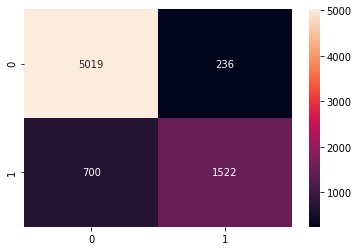

In [0]:
print_scores(tempDf['ActualValue'], tempDf['PredictedClass'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


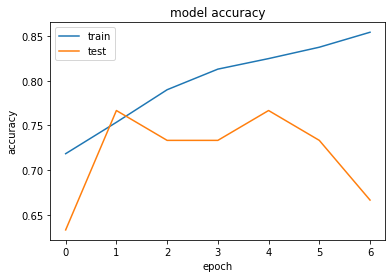

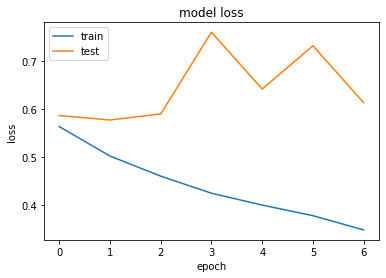

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### SECOND MODEL BEGINS HERE FOR GROUP L12 (0) - All assignment groups that falls under L12 defined above

In [0]:
# get the train test data for the actual assignment groups
X_train_Zero, Y_train_Zero, X_validation_Zero, Y_validation_Zero,X_train_One, X_validation_One, Y_train_One, Y_validation_One, partDfZero, partDfOne, classweightZero, classweightOne  = PrepDataForModel_SecondLevelGrouping(df, maxlen)

In [0]:
# SECOND MODEL BEGINS HERE FOR GROUP 1 - All assignment groups that falls under L12 defined above

model_L12_AssignmentGroups = Sequential()
embedding=Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen,trainable=False)

model_L12_AssignmentGroups.add(embedding)

model_L12_AssignmentGroups.add(Bidirectional(LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5)))
model_L12_AssignmentGroups.add(Bidirectional(LSTM(maxlen, return_sequences=False)))

#model_L12_AssignmentGroups.add(LSTM(maxlen))
#model_L12_AssignmentGroups.add(Dense(100, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.5) )
#model_L12_AssignmentGroups.add(Dense(80, activation='relu'))


model_L12_AssignmentGroups.add(Dense(len(L12), activation='softmax'))
model_L12_AssignmentGroups.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [0]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

history=model_L12_AssignmentGroups.fit(X_train_Zero,Y_train_Zero,batch_size=32,epochs=10, class_weight = classweightZero,
                                                   validation_data=(X_validation_Zero,Y_validation_Zero),
                                                   callbacks=[early], 
                                                   verbose=1)

scores = model_L12_AssignmentGroups.evaluate(X_validation_Zero, Y_validation_Zero, verbose=1)
model_L12_AssignmentGroups.save("model_L12_AssignmentGroups.h5")

Train on 3691 samples, validate on 1582 samples
Epoch 1/10
3691/3691 [==============================] - 116s 31ms/step - loss: 0.1913 - acc: 0.9339 - val_loss: 0.1670 - val_acc: 0.9398
Epoch 2/10
3691/3691 [==============================] - 112s 30ms/step - loss: 0.1465 - acc: 0.9471 - val_loss: 0.1475 - val_acc: 0.9457
Epoch 3/10
3691/3691 [==============================] - 111s 30ms/step - loss: 0.1275 - acc: 0.9510 - val_loss: 0.1365 - val_acc: 0.9490
Epoch 4/10
3691/3691 [==============================] - 112s 30ms/step - loss: 0.1205 - acc: 0.9530 - val_loss: 0.1307 - val_acc: 0.9497
Epoch 5/10
3691/3691 [==============================] - 109s 30ms/step - loss: 0.1121 - acc: 0.9560 - val_loss: 0.1324 - val_acc: 0.9486
Epoch 6/10
3691/3691 [==============================] - 108s 29ms/step - loss: 0.1065 - acc: 0.9584 - val_loss: 0.1395 - val_acc: 0.9486
Epoch 7/10
3691/3691 [==============================] - 108s 29ms/step - loss: 0.1009 - acc: 0.9600 - val_loss: 0.1315 - val_acc: 

Accuracy score: 
 0.8721213763207802
Test-set confusion matrix:
 [[2313   15    4    9    4    0    2    1]
 [  12  136    0    1    0    0   10    1]
 [  71    5   61    1    6    0    0    1]
 [  42    4    0  123    1    0    0    0]
 [  62    3   15    3   46    0    0    0]
 [   0    0    0    0    0   64   42    9]
 [   3    3    0    0    0    3  424   15]
 [  10    1    0    0    0    4  109   52]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      2348
           1       0.81      0.85      0.83       160
           2       0.76      0.42      0.54       145
           3       0.90      0.72      0.80       170
           4       0.81      0.36      0.49       129
           5       0.90      0.56      0.69       115
           6       0.72      0.95      0.82       448
           7       0.66      0.30      0.41       176

    accuracy                           0.87      3691
   macro avg       0.81 

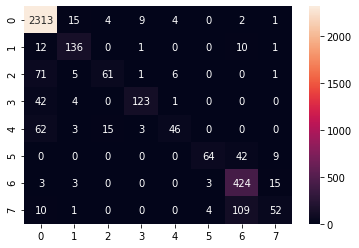

In [0]:
y = model_L12_AssignmentGroups.predict(X_train_Zero)
predictedClass = np.argmax(y,axis=1).tolist()
actualClass = np.argmax(Y_train_Zero,axis=1).tolist()
    
tempDf_L12_AssignmentGroups = pd.DataFrame()
tempDf_L12_AssignmentGroups['ActualValue'] = pd.Series(actualClass)
tempDf_L12_AssignmentGroups['PredictedClass'] = pd.Series(predictedClass)
print_scores(tempDf_L12_AssignmentGroups['ActualValue'], tempDf_L12_AssignmentGroups['PredictedClass'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


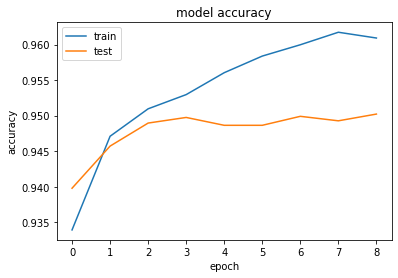

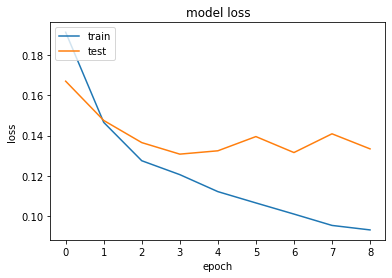

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### SECOND MODEL BEGINS HERE FOR GROUP L3 (1)  - All assignment groups that falls under L3 defined above


In [0]:
# SECOND MODEL BEGINS HERE FOR GROUP 2  - All assignment groups that falls under L3 defined above

model_L3_AssignmentGroups = Sequential()
embedding = Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen, trainable=False)

model_L3_AssignmentGroups.add(embedding)

#model_L3_AssignmentGroups.add(LSTM(maxlen), recurrent_dropout=0.25)


model_L3_AssignmentGroups.add(Bidirectional(LSTM(maxlen, return_sequences=True, recurrent_dropout=0.3)))
model_L3_AssignmentGroups.add(Bidirectional(LSTM(maxlen, return_sequences=False)))

model_L3_AssignmentGroups.add(Dense(100, activation='relu'))
model_L3_AssignmentGroups.add(Dropout(0.25) )

#L3 subgroups
model_L3_AssignmentGroups.add(Dense(len(L3), activation='softmax'))
model_L3_AssignmentGroups.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [0]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)


history=model_L3_AssignmentGroups.fit(X_train_One,Y_train_One, batch_size=10,epochs=10, class_weight = classweightOne,
                                      validation_data=(X_validation_One,Y_validation_One),
                                      callbacks=[early], 
                                      verbose=1)

scores = model_L3_AssignmentGroups.evaluate(X_validation_One, Y_validation_One, verbose=1)

model_L3_AssignmentGroups.save("model_L3_AssignmentGroups.h5")

Train on 1563 samples, validate on 671 samples
Epoch 1/10
1563/1563 [==============================] - 153s 98ms/step - loss: 0.0664 - acc: 0.9850 - val_loss: 0.0557 - val_acc: 0.9861
Epoch 2/10
1563/1563 [==============================] - 152s 97ms/step - loss: 0.0539 - acc: 0.9862 - val_loss: 0.0493 - val_acc: 0.9870
Epoch 3/10
1563/1563 [==============================] - 156s 100ms/step - loss: 0.0477 - acc: 0.9871 - val_loss: 0.0459 - val_acc: 0.9870
Epoch 4/10
1563/1563 [==============================] - 154s 98ms/step - loss: 0.0428 - acc: 0.9878 - val_loss: 0.0436 - val_acc: 0.9876
Epoch 5/10
1563/1563 [==============================] - 152s 97ms/step - loss: 0.0386 - acc: 0.9884 - val_loss: 0.0429 - val_acc: 0.9874
Epoch 6/10
1563/1563 [==============================] - 149s 96ms/step - loss: 0.0369 - acc: 0.9887 - val_loss: 0.0425 - val_acc: 0.9883
Epoch 7/10
1563/1563 [==============================] - 148s 95ms/step - loss: 0.0320 - acc: 0.9897 - val_loss: 0.0414 - val_acc: 

In [0]:
y = model_L3_AssignmentGroups.predict(X_train_One)
predictedClass = np.argmax(y,axis=1).tolist()
actualClass = np.argmax(Y_train_One,axis=1).tolist()
    
tempDf_L3_AssignmentGroups = pd.DataFrame()
tempDf_L3_AssignmentGroups['ActualValue'] = pd.Series(actualClass)
tempDf_L3_AssignmentGroups['PredictedClass'] = pd.Series(predictedClass)

Accuracy score: 
 0.7594369801663468
Test-set confusion matrix:
 [[15  0  0 ...  0  0  0]
 [ 0 83  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.71      0.61        21
           1       0.65      0.86      0.74        96
           2       0.81      0.65      0.72        20
           3       0.69      0.92      0.79        96
           4       0.94      0.85      0.89        85
           5       0.86      0.60      0.71        30
           6       1.00      0.85      0.92        52
           7       1.00      1.00      1.00        52
           8       0.72      0.88      0.79        58
           9       0.75      0.11      0.19        27
          10       0.81      0.68      0.74        19
          11       0.50      0.90      0.64        21
          12       0.83      0.94      0.88        1

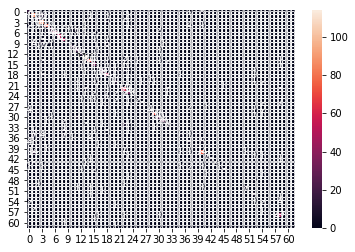

In [0]:
print_scores(tempDf_L3_AssignmentGroups['ActualValue'], tempDf_L3_AssignmentGroups['PredictedClass'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


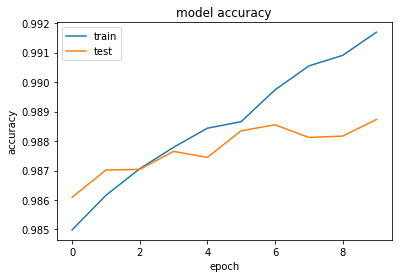

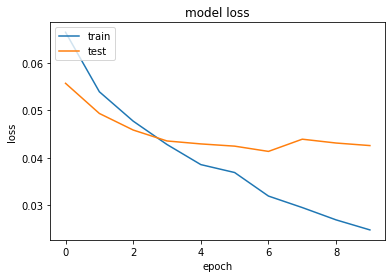

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
PickleCustomObjects(embeddings,vocabulary,inverse_vocabulary)

#### Random Forest Method

In [0]:
df = pd.read_excel('EDA_Cleaned_PreProcessed.xlsx')
dfModelBuilding = df[['LemmaString', 'AssignmentGroup']]
dfModelBuilding.head()

LemmaString AssignmentGroup
0    login issue verified user details employee m...           GRP_0
1    outlook hmjdrvpb komuaywn team meetings skyp...           GRP_0
2                    log vpn eylqgodm ybqkwiam i not           GRP_0
3                              unable access hr tool           GRP_0
4                                        skype error           GRP_0

In [0]:
dfModelBuilding = dfModelBuilding.dropna()
dfModelBuilding = dfModelBuilding.reset_index(drop=True)

cols = ['LemmaString','AssignmentGroup']
dfModelBuilding[cols] = dfModelBuilding[cols].fillna('no data')

In [0]:
dfModelBuilding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7504 entries, 0 to 7503
Data columns (total 2 columns):
LemmaString        7504 non-null object
AssignmentGroup    7504 non-null object
dtypes: object(2)
memory usage: 117.4+ KB


In [0]:
dfModelBuilding['L12Grp'] = dfModelBuilding['AssignmentGroup'].apply(lambda x : SetGrp(x))

In [0]:
dfModelBuilding.head()

LemmaString  ... L12Grp
0    login issue verified user details employee m...  ...      0
1    outlook hmjdrvpb komuaywn team meetings skyp...  ...      0
2                    log vpn eylqgodm ybqkwiam i not  ...      0
3                              unable access hr tool  ...      0
4                                        skype error  ...      0

[5 rows x 4 columns]

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

In [0]:
dfModelBuilding_1 = dfModelBuilding[['LemmaString','AssignmentGroup','L12Grp']]
dfModelBuilding_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7504 entries, 0 to 7503
Data columns (total 3 columns):
LemmaString        7504 non-null object
AssignmentGroup    7504 non-null object
L12Grp             7504 non-null int64
dtypes: int64(1), object(2)
memory usage: 176.0+ KB


##### Random Forest - Train Random Forest for L12 and L3 groups




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


0.8067954696868754


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.7s finished


Accuracy score: 
 0.8067954696868754
Test-set confusion matrix:
 [[980  75]
 [215 231]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1055
           1       0.75      0.52      0.61       446

    accuracy                           0.81      1501
   macro avg       0.79      0.72      0.74      1501
weighted avg       0.80      0.81      0.79      1501



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


0.8081279147235176


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.7s finished


Accuracy score: 
 0.8081279147235176
Test-set confusion matrix:
 [[992  63]
 [225 221]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87      1055
           1       0.78      0.50      0.61       446

    accuracy                           0.81      1501
   macro avg       0.80      0.72      0.74      1501
weighted avg       0.80      0.81      0.79      1501



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


0.8147901399067289


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.6s finished


Accuracy score: 
 0.8147901399067289
Test-set confusion matrix:
 [[996  59]
 [219 227]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      1055
           1       0.79      0.51      0.62       446

    accuracy                           0.81      1501
   macro avg       0.81      0.73      0.75      1501
weighted avg       0.81      0.81      0.80      1501



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


0.8134576948700866


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.6s finished


Accuracy score: 
 0.8134576948700866
Test-set confusion matrix:
 [[1006   48]
 [ 232  215]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      1054
           1       0.82      0.48      0.61       447

    accuracy                           0.81      1501
   macro avg       0.82      0.72      0.74      1501
weighted avg       0.81      0.81      0.80      1501



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


0.7993333333333333


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.6s finished


Accuracy score: 
 0.7993333333333333
Test-set confusion matrix:
 [[974  80]
 [221 225]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1054
           1       0.74      0.50      0.60       446

    accuracy                           0.80      1500
   macro avg       0.78      0.71      0.73      1500
weighted avg       0.79      0.80      0.79      1500



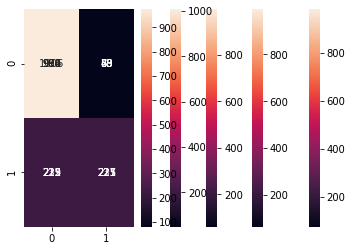

In [0]:
data_x = dfModelBuilding_1['LemmaString'].values
data_y = dfModelBuilding_1['L12Grp'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in skf.split(data_x, data_y):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

    clf=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    y_pred_prob = clf.predict_proba(dfModelBuilding_1['LemmaString'])
    print_scores(y_test, y_pred, y_pred_prob)

In [0]:
#Seperate Class 0 and Class 1 into different data frames

partDfZero = dfModelBuilding.loc[dfModelBuilding['L12Grp'] == 0]
partDfOne = dfModelBuilding.loc[dfModelBuilding['L12Grp'] == 1]

In [0]:
le1 = LabelEncoder()
le2 = LabelEncoder()

partDfZero['AssignmentGroup'] = le1.fit_transform(partDfZero['AssignmentGroup'])
partDfOne['AssignmentGroup'] = le2.fit_transform(partDfOne['AssignmentGroup'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


##### Use Stratified K Fold and Random Forest on to train/predict L12 group sub-groups

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finis

0.8026166097838453
Accuracy score: 
 0.8026166097838453
Test-set confusion matrix:
 [[1088    6    1    1    5    1    0    0]
 [  27   52    0    1    0    0    3    0]
 [  62    1    3    0    1    0    0    0]
 [  52    0    0   26    1    0    0    0]
 [  50    0    3    2   10    0    0    0]
 [   9    0    0    0    0   19   22    9]
 [   8    7    0    0    0    1  196    8]
 [  19    1    0    0    0    0   46   17]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1102
           1       0.78      0.63      0.69        83
           2       0.43      0.04      0.08        67
           3       0.87      0.33      0.48        79
           4       0.59      0.15      0.24        65
           5       0.90      0.32      0.48        59
           6       0.73      0.89      0.80       220
           7       0.50      0.20      0.29        83

    accuracy                           0.80      1758
   ma

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finis

0.8048919226393629
Accuracy score: 
 0.8048919226393629
Test-set confusion matrix:
 [[1088   10    1    0    1    2    0    0]
 [  23   51    0    2    0    0    7    0]
 [  61    0    3    0    2    0    1    0]
 [  50    0    0   28    1    0    0    0]
 [  51    0    1    0   12    0    0    0]
 [   4    0    0    0    0   27   21    8]
 [  11    7    0    0    0    1  190   10]
 [  21    0    0    0    0    0   47   16]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1102
           1       0.75      0.61      0.68        83
           2       0.60      0.04      0.08        67
           3       0.93      0.35      0.51        79
           4       0.75      0.19      0.30        64
           5       0.90      0.45      0.60        60
           6       0.71      0.87      0.78       219
           7       0.47      0.19      0.27        84

    accuracy                           0.80      1758
   ma

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finis

0.8002276607854297
Accuracy score: 
 0.8002276607854297
Test-set confusion matrix:
 [[1090    4    0    1    3    0    2    1]
 [  33   45    0    1    0    0    4    0]
 [  57    0    4    1    4    0    2    0]
 [  55    0    0   23    0    0    0    0]
 [  54    0    0    2    9    0    0    0]
 [   8    0    0    0    0   23   25    4]
 [   8    2    0    0    0    2  198    9]
 [  25    0    0    0    0    0   44   14]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      1101
           1       0.88      0.54      0.67        83
           2       1.00      0.06      0.11        68
           3       0.82      0.29      0.43        78
           4       0.56      0.14      0.22        65
           5       0.92      0.38      0.54        60
           6       0.72      0.90      0.80       219
           7       0.50      0.17      0.25        83

    accuracy                           0.80      1757
   ma

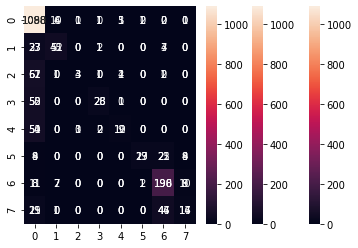

In [0]:
data_x2 = partDfZero['LemmaString'].values
data_y2 = partDfZero['AssignmentGroup'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for train_index, test_index in skf.split(data_x2, data_y2):
    x_train2, x_test2 = data_x2[train_index], data_x2[test_index]
    y_train2, y_test2 = data_y2[train_index], data_y2[test_index]

    clf2=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])
    clf2.fit(x_train2, y_train2)
    y_pred2 = clf2.predict(x_test2)
    y_pred_prob2 = clf2.predict_proba(x_test2)
    score2 = accuracy_score(y_test2, y_pred2)
    print(score2)
    print_scores(y_test2, y_pred2, y_pred_prob2)
    print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test2, y_pred2))

##### Random Forest and Stratified K Fold to train/predict L3 subgroups

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  4

0.5928411633109619
Accuracy score: 
 0.5928411633109619
Test-set confusion matrix:
 [[ 0  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.67      0.64      0.65        28
           2       0.00      0.00      0.00         6
           3       0.41      0.79      0.54        29
           4       0.55      0.74      0.63        23
           5       0.67      0.29      0.40         7
           6       0.79      0.88      0.83        17
           7       0.83      1.00      0.91        15
           8       0.64      0.53      0.58        17
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       1.00      0.17      0.29         6
          12       0.67      0.80      0.73         5
          13       0.65      0.86      0.74        35
          14       0.53      0.87      0.66        23
          15       0.40      0.55      0.46        11
          16       0.00      0.00      0.00         3
   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finis

0.600896860986547
Accuracy score: 
 0.600896860986547
Test-set confusion matrix:
 [[ 2  0  0 ...  0  0  0]
 [ 0 14  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.67      0.50      0.57        28
           2       0.00      0.00      0.00         6
           3       0.36      0.79      0.49        28
           4       0.67      0.58      0.62        24
           5       1.00      0.71      0.83         7
           6       1.00      0.76      0.87        17
           7       0.94      1.00      0.97        15
           8       0.59      0.59      0.59        17
           9       0.00      0.00      0.00         7
          10       0.50      0.17      0.25         6
          11       0.50      0.67      0.57         6
          12       0.83      1.00      0.91         5
          13       0.72      0.94      0.81        35
          14       0.50      0.83      0.62        23
          15       0.86      0.60      0.71        10
          16       0.00      0.00      0.00         4
   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finis

0.5717488789237668
Accuracy score: 
 0.5717488789237668
Test-set confusion matrix:
 [[ 1  0  0 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.53      0.57      0.55        28
           2       0.00      0.00      0.00         6
           3       0.45      0.82      0.58        28
           4       0.56      0.87      0.68        23
           5       0.33      0.25      0.29         8
           6       0.87      0.76      0.81        17
           7       1.00      0.93      0.96        14
           8       0.67      0.56      0.61        18
           9       0.00      0.00      0.00         7
          10       1.00      0.20      0.33         5
          11       0.50      0.57      0.53         7
          12       1.00      1.00      1.00         5
          13       0.66      0.94      0.78        35
          14       0.56      0.68      0.61        22
          15       0.33      0.36      0.35        11
          16       0.00      0.00      0.00         4
   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finis

0.5650224215246636
Accuracy score: 
 0.5650224215246636
Test-set confusion matrix:
 [[ 0  0  0 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      0.57      0.53        28
           2       0.00      0.00      0.00         6
           3       0.43      0.71      0.53        28
           4       0.38      0.48      0.42        23
           5       0.86      0.75      0.80         8
           6       0.72      0.81      0.76        16
           7       0.88      1.00      0.94        15
           8       0.67      0.71      0.69        17
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.33      0.33      0.33         6
          12       1.00      1.00      1.00         5
          13       0.74      0.81      0.77        36
          14       0.53      0.86      0.66        22
          15       0.55      0.55      0.55        11
          16       0.00      0.00      0.00         3
   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finis

0.5627802690582959
Accuracy score: 
 0.5627802690582959
Test-set confusion matrix:
 [[ 1  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  1  0 ...  0 11  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.69      0.41      0.51        27
           2       1.00      0.17      0.29         6
           3       0.43      0.79      0.55        29
           4       0.43      0.52      0.47        23
           5       0.67      0.29      0.40         7
           6       0.85      0.65      0.73        17
           7       0.94      1.00      0.97        15
           8       0.50      0.41      0.45        17
           9       0.00      0.00      0.00         7
          10       1.00      0.17      0.29         6
          11       0.67      0.33      0.44         6
          12       0.71      1.00      0.83         5
          13       0.62      0.74      0.68        35
          14       0.50      0.70      0.58        23
          15       0.58      0.64      0.61        11
          16       0.00      0.00      0.00         3
   

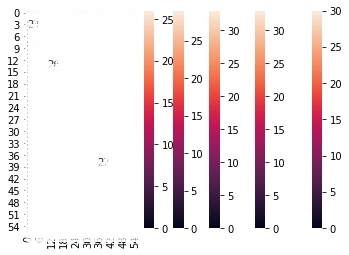

In [0]:
data_x3 = partDfOne['LemmaString'].values
data_y3 = partDfOne['AssignmentGroup'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in skf.split(data_x3, data_y3):
    x_train3, x_test3 = data_x3[train_index], data_x3[test_index]
    y_train3, y_test3 = data_y3[train_index], data_y3[test_index]

    clf3=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])
    clf3.fit(x_train3, y_train3)
    y_pred3 = clf3.predict(x_test3)
    y_pred_prob3 = clf3.predict_proba(x_test3)
    score3 = accuracy_score(y_test3, y_pred3)
    print(score3)
    print_scores(y_test3, y_pred3, y_pred_prob3)
    print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test3, y_pred3))

##### Model Evaluation
Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction<br>
We have used stratified K fold cross validation technique to train our data. With stratified K fold, the splitting of data will ensure that each fold has the same proportion of observations with a given categorical value, in our case “L12Grp” and “Assignment Group”

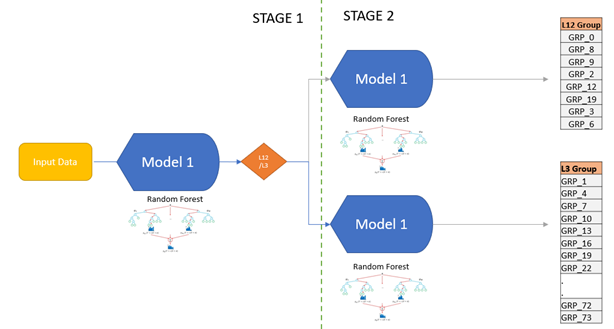

<br><br>

The accuracy for L12 team is coming out to be fairly good around 80 % but for L3 teams it is coming out be as low as 56 %. This is because L3 contains a greater number of groups and not able to build an efficient classification model. 

##### Learning from the approach

•	For L3 model, for most of the groups the recall was coming out 0<br>
 
•	We observed that for stage 1 binary classification, random forest did well whereas for stage 2 multiclass classification LSTM performed better <br>

•	Skewed data is making our model not quite effective and need for oversampling has become a prime requirement. <br>
Stacked RNN models performed good in training data where as we have not been able to achieve good accuracy with classical machine learning models. <br>
To handle imbalance of data we have identified L12 and L3 team groups and decided to predict them separately. <br> 
As our next approach we will try oversampling out data. We will create entries for our minority classes and will oversample them to have fairly equal distribution in the data. <br>

### Approach 5 - Oversampling Approach

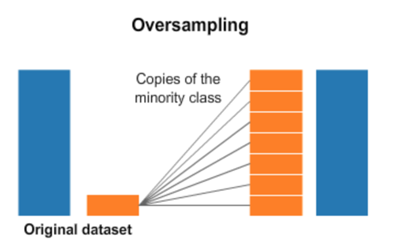

To cater the problem of imbalance data, we have tried another approach of handle our minority class i.e. to up-sample them to make our distribution across target variable more balanced. <br>
There exist many oversampling techniques in the area of machine learning such as SMOTE (Synthetic Minority Over-Sampling Technique) or RandomOverSampler within imbalanced-learn package. Other techniques involve understanding the context of minority classes and creating sentences or jumbling or using key words from the data and generating new data.<br>
Other techniques involve understanding the context of the text in minority classes and generating text of same context or jumbling the words or identifying key words from the data and build synthetic data based on it. But since our most of the minority classes i.e. groups have only one entry compared to thousands of entries of majority class, these techniques might not result in efficient balancing of the data.
We will be using below technique to oversample our data:  <br><br>

Random oversampling for the minority class<br><br>

Random oversampling simply replicates randomly the minority class examples. Random oversampling is known to increase the likelihood of occurring overfitting.<br>
The increase in the number of examples for the minority class, especially if the class skew was severe, can also result in a marked increase in the computational cost when fitting the model, especially considering the model is seeing the same examples in the training dataset again and again.<br>




In [0]:
df = pd.read_excel('EDA_Cleaned_PreProcessed.xlsx')
df.head()

Assignment group  ...                                        LemmaString
0            GRP_0  ...    login verified details employee manager chec...
1            GRP_0  ...    outlook hmjdrvpb komuaywn team meetings skyp...
2            GRP_0  ...                      log vpn eylqgodm ybqkwiam not
3            GRP_0  ...                                                 hr
4            GRP_0  ...                                              skype

[5 rows x 7 columns]

In [0]:
final_df = df[['LemmaString','Assignment group']].copy()

In [0]:
final_df.head()

LemmaString Assignment group
0    login verified details employee manager chec...            GRP_0
1    outlook hmjdrvpb komuaywn team meetings skyp...            GRP_0
2                      log vpn eylqgodm ybqkwiam not            GRP_0
3                                                 hr            GRP_0
4                                              skype            GRP_0

In [0]:
df1 = final_df.copy()

df1['New group'] = LabelEncoder().fit_transform(df1['Assignment group'])
df1.head()

LemmaString  ... New group
0    login verified details employee manager chec...  ...         0
1    outlook hmjdrvpb komuaywn team meetings skyp...  ...         0
2                      log vpn eylqgodm ybqkwiam not  ...         0
3                                                 hr  ...         0
4                                              skype  ...         0

[5 rows x 3 columns]

In [0]:
df2 = df1[['New group','LemmaString']].copy()

In [0]:
df2.head()

New group                                        LemmaString
0          0    login verified details employee manager chec...
1          0    outlook hmjdrvpb komuaywn team meetings skyp...
2          0                      log vpn eylqgodm ybqkwiam not
3          0                                                 hr
4          0                                              skype

#### Model Building

In [0]:
max_features = 10000
embedding_size = 50

In [0]:
def create_corpus(df):
    corpus=[]
    for desc in tqdm(df['LemmaString'].astype(str)):
        words=[word.lower() for word in word_tokenize(desc) if((word.isalpha()==1))] # & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [0]:
def create_inputvector(data,max_features,embedding_size,target):
  corpus = create_corpus(data)

  nb_words = []
  for i in range(len(data['LemmaString'])):
    nb_words.append(len(data['LemmaString'].iloc[i].split()))

  data['nb_words'] = nb_words
  print(data.columns)
  maxlen = max(data['nb_words'])

  tokenizer_obj=Tokenizer(num_words=max_features)
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)

  word_index = tokenizer_obj.word_index
  num_words = len(word_index)+1

  X = tokenizer_obj.texts_to_sequences(corpus)
  X = pad_sequences(X, maxlen = maxlen)
  y1 = data[target]
  y = to_categorical(y1, num_classes=74)
  return X,y,y1,maxlen,num_words

In [0]:
X,y,y1,maxlen,num_words=create_inputvector(data=df2,max_features=max_features,embedding_size=embedding_size,target='New group')

100%|██████████| 8500/8500 [00:01<00:00, 7871.30it/s]


Index(['New group', 'LemmaString', 'nb_words'], dtype='object')


#### Performing oversampling

In [0]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ROS = RandomOverSampler(sampling_strategy='auto', random_state=42)

x_res, y_res = ROS.fit_sample(X, y1)

for i in range(y1.unique().shape[0]-2):
  ROS = RandomOverSampler(sampling_strategy='auto', random_state=42)
  x_res, y_res = ROS.fit_sample(x_res, y_res)

In [0]:
print ("Distribution of class labels before resampling {}".format(Counter(y1)))
print ("Distribution of class labels after resampling {}".format(Counter(y_res)))

Distribution of class labels before resampling Counter({0: 3976, 72: 661, 17: 289, 4: 257, 73: 252, 12: 241, 11: 215, 23: 200, 56: 184, 5: 145, 2: 140, 45: 129, 6: 118, 18: 116, 27: 107, 34: 100, 22: 97, 10: 88, 8: 85, 9: 81, 25: 69, 67: 68, 28: 62, 19: 56, 35: 45, 21: 44, 36: 40, 7: 39, 24: 39, 37: 37, 13: 36, 40: 35, 1: 31, 15: 31, 3: 30, 14: 29, 42: 27, 16: 25, 43: 25, 59: 25, 57: 20, 33: 19, 20: 18, 31: 16, 30: 15, 39: 15, 46: 14, 49: 11, 62: 11, 48: 9, 47: 8, 51: 8, 41: 6, 44: 6, 55: 6, 38: 5, 26: 4, 63: 4, 32: 3, 52: 3, 54: 3, 60: 3, 65: 3, 50: 2, 53: 2, 66: 2, 69: 2, 70: 2, 29: 1, 58: 1, 61: 1, 64: 1, 68: 1, 71: 1})
Distribution of class labels after resampling Counter({0: 3976, 1: 3976, 23: 3976, 34: 3976, 45: 3976, 56: 3976, 67: 3976, 72: 3976, 73: 3976, 2: 3976, 3: 3976, 4: 3976, 5: 3976, 6: 3976, 7: 3976, 8: 3976, 9: 3976, 10: 3976, 11: 3976, 12: 3976, 13: 3976, 14: 3976, 15: 3976, 16: 3976, 17: 3976, 18: 3976, 19: 3976, 20: 3976, 21: 3976, 22: 3976, 24: 3976, 25: 3976, 27: 

In [0]:
y_res1 = to_categorical(y_res, num_classes=74)

In [0]:
batch_size = 512
epochs = 5

In [0]:
def LSTM_model(maxlen,batch_size,epochs):
  main_input = Input(shape=(maxlen,))
  em = Embedding(max_features, 100, input_length=maxlen) (main_input)

  lstm_out1 = LSTM(128, return_sequences = True)(em)
  lstm_out2 = LSTM(128)(lstm_out1)

  x = Dropout(0.2)(lstm_out2)

  main_output = Dense(74, activation = 'softmax')(x)

  model = Model(inputs = main_input, outputs = main_output)
  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                               save_weights_only=True, mode="min", period=1)
  stop = EarlyStopping(monitor="loss", patience=5, mode="min")
  reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
  print(model.summary())
  return model,checkpoint,stop,reduce_lr


In [0]:
def plot_graph(history):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
  fig.suptitle("Performance: LSTM Model")
  ax1.plot(history.history['acc'])
  ax1.plot(history.history['val_acc'])
  cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
  ax1.axvline(x=cut, color='k', linestyle='--')
  ax1.set_title("Model Accuracy")
  ax1.legend(['train', 'test'])

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
  ax2.axvline(x=cut, color='k', linestyle='--')
  ax2.set_title("Model Loss")
  ax2.legend(['train', 'test'])

In [0]:
skf = StratifiedKFold(n_splits=5,random_state=24, shuffle=True)
models, measures = [], []
for index, (train_indices, val_indices) in enumerate(skf.split(x_res, y_res)):
   ## Extract Kfold
  X_train_sfk, X_test_sfk = x_res[train_indices], x_res[val_indices]
  y_train_sfk, y_test_sfk = y_res[train_indices], y_res[val_indices]

In [0]:
y_train_sfk = to_categorical(y_train_sfk, num_classes= 74)

In [0]:
y_test_sfk = to_categorical(y_test_sfk,num_classes=74)

In [0]:
model2,checkpoint2,stop2,reduce_lr2 = LSTM_model(maxlen=maxlen,batch_size=batch_size,epochs=epochs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 415)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 415, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 415, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                9546      
Total params: 1,258,378
Trainable params: 1,258,378
Non-trainable params: 0
_________________________________________________

In [0]:
history2 = model2.fit(X_train_sfk, y_train_sfk, validation_data=(X_test_sfk,y_test_sfk), batch_size=batch_size, epochs=epochs, callbacks=[stop2,reduce_lr2]) #, class_weight = 'auto')

Train on 235380 samples, validate on 58844 samples
Epoch 1/5
235380/235380 [==============================] - 5137s 22ms/step - loss: 1.4134 - acc: 0.6588 - val_loss: 0.3690 - val_acc: 0.9045
Epoch 2/5
235380/235380 [==============================] - 5115s 22ms/step - loss: 0.2993 - acc: 0.9167 - val_loss: 0.2455 - val_acc: 0.9286
Epoch 3/5
235380/235380 [==============================] - 5133s 22ms/step - loss: 0.2351 - acc: 0.9291 - val_loss: 0.2059 - val_acc: 0.9329
Epoch 4/5
235380/235380 [==============================] - 5089s 22ms/step - loss: 0.2080 - acc: 0.9340 - val_loss: 0.1960 - val_acc: 0.9371
Epoch 5/5
235380/235380 [==============================] - 5106s 22ms/step - loss: 0.1935 - acc: 0.9368 - val_loss: 0.1877 - val_acc: 0.9392


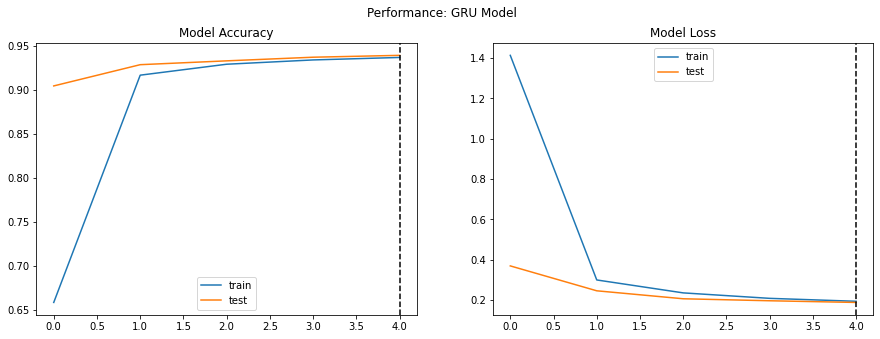

In [0]:
plot_graph(history2)

Accuracy score: 
 0.9349636326558358
Test-set confusion matrix:
 [[476   3  11 ...   0   8   2]
 [  0 795   0 ...   0   0   0]
 [  0   0 665 ...   0   0   0]
 ...
 [  0   0   0 ... 795   0   0]
 [  8   7   2 ...   0 418   0]
 [  0   0   0 ...   0   0 282]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67       795
           1       0.89      1.00      0.94       795
           2       0.98      0.84      0.90       796
           3       0.99      1.00      1.00       795
           4       0.93      0.94      0.93       795
           5       1.00      0.98      0.99       795
           6       0.99      0.96      0.97       795
           7       0.99      1.00      1.00       796
           8       0.99      0.99      0.99       795
           9       1.00      1.00      1.00       795
          10       1.00      0.96      0.98       795
          11       0.96      0.93      0.95       795
          12    

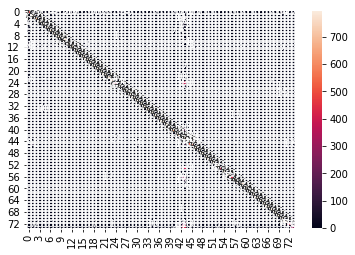

In [0]:
y = model2.predict(X_test_sfk)
predictedClass = np.argmax(y,axis=1).tolist()
actualClass = np.argmax(y_test_sfk,axis=1).tolist()

tempDf_L12_AssignmentGroups = pd.DataFrame()
tempDf_L12_AssignmentGroups['ActualValue'] = pd.Series(actualClass)
tempDf_L12_AssignmentGroups['PredictedClass'] = pd.Series(predictedClass)
print_scores(tempDf_L12_AssignmentGroups['ActualValue'], tempDf_L12_AssignmentGroups['PredictedClass'])

####  Learning from the approach

•	The accuracy is coming out to be really good reaching a satisfactory 94%. Oversampling the data and making the distribution more uniform has resulted in much better results.<br>
•	Precision and Recall has also come very good.<br>
•	F1 Score is also very good.<br>
•	As anticipated the computational cost has been increased significantly as well with each epoch running for nearly 1 hour.

# PERFORMANCE COMPARISON

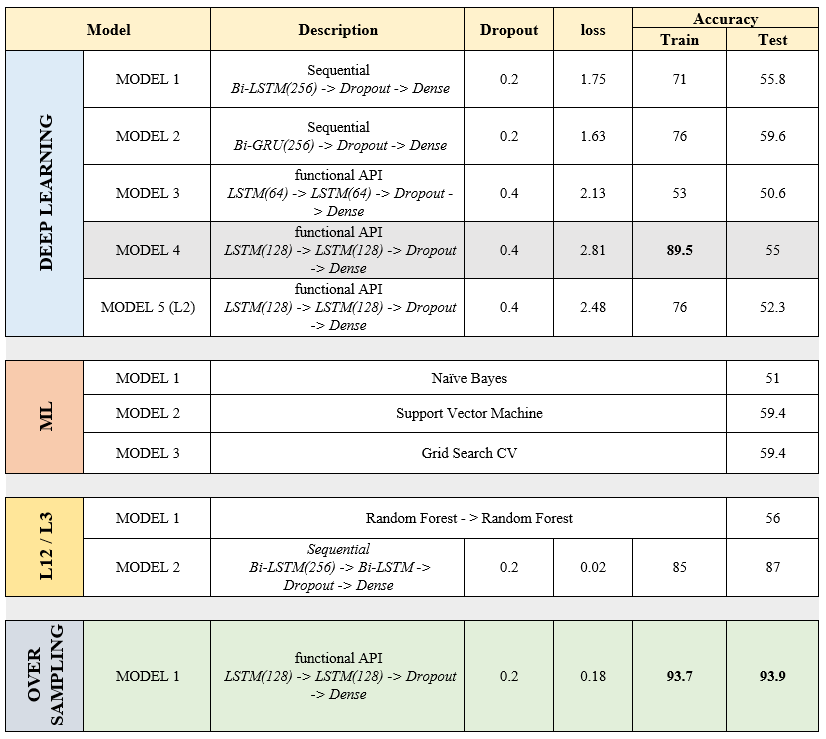

# FINAL SOLUTION
Accordingly, we decided to submit the LSTM model with up-sampled data to be our final model for submission as the model is not over-fitting and is providing high train and validation accuracy as 93.68 % and 93.92%, respectively.<br>
As part of the preprocessing step we will be including the step to oversample out data using random over sampler and create more samples of the minority class. 

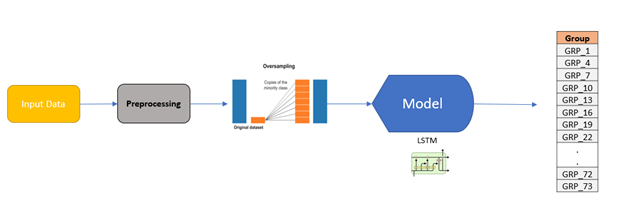

# LIMITATIONS

•	The dataset is highly imbalanced considering our target variable which could affect the performance measurement criteria of our classification model. 

•	Handling of multiple language data and junk characters.

•	The ‘langdetect’ and ’googletrans’ library works much better for longer strings where it can sample more n-grams. For short strings of a few words, it's not quite reliable.

•	Language is detected more correctly for English and German but quite incorrectly for other languages.

•	Adding caller to input feature was not adding significant improvement so we have assumed that the ‘Caller’ attribute does not include valuable information. 

•	Even though, the submitted model (oversampling approach) has high accuracy, it is taking too much time to train. The model can be upgraded to run faster, almost in real-time or near real-time or saving the model weights and using it through transfer learning. 

# CLOSING REFLECTIONS

The journey from beginning to the submission of the Capstone Project has been very educative. Being the real-world problem, it seemed very difficult at the beginning to solve the problem as we struggled a lot in achieving desirable accuracy of the model which can be put in real world. During the journey of achieving the milestones, we have learned many new NLP techniques which are actually used in real-world problem-solving processes. <br><br>
As we came across some mandatory steps to be followed in Text Processing, we can directly start with the same in next project, which can save a lot of time. Further, we can work towards reducing latency in the present model. <br><br>
For next time, we may start with unsupervised techniques like clustering and build clusters out of data and try to learn the ground truth by building models on top of it.<br><br>
We may try different libraries such as BERT next time which we have not used at this time to achieve the milestone. Also, for dealing with multi language data, since google translate was not giving satisfactory results, a more custom based translation system could be needed. For oversampling, more methods could be explored or business tailored system could be built for data synthesis. We would explore more hyperparameters and how they could affect the performance.<br><br>
Overall, the experience has been very intuitive and full of learning and gives a snippet of real-world idea. 


                                                          THANK YOU